# Batch Processing of Plots using the Selection for Data

NUE SELECTION

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [43]:
import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

In [44]:
params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [45]:
# Set False if doing Run 1, True if doing Run 3

isRun3 = False

ending = "Jan19b"

## NUE_NUE SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/numi_run1_nue_overlay_fhc'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/numi_run3b_nue_overlay_rhc'+ls.APPEND

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt", 'swtrig_pre',            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)
nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

['shr_energy_tot_cali', 'n_showers_contained', 'trk_energy', 'shr_tkfit_dedx_U', 'nu_pdg', 'shrsubclusters0', 'npi0', 'topological_score', 'nslice', 'shr_pz', 'tksh_distance', 'contained_fraction', 'shrsubclusters2', 'selected', 'elec_e', 'n_showers', 'trk_score_v', 'flash_time', 'shr_energy', 'category', 'shr_px', 'shr_tkfit_dedx_Y', 'trkshrhitdist2', 'n_tracks_contained', 'shr_tkfit_npoints', 'shr_score', 'npion', 'shr_distance', 'shr_theta', 'shr_energy_cali', 'shrsubclusters1', 'nproton', 'shr_py', 'proton_e', 'shr_tkfit_nhits_V', 'swtrig_pre', 'shr_tkfit_dedx_V', 'trk_energy_tot', 'reco_nu_vtx_sce_x', 'CosmicIPAll3D', 'n_tracks', 'shr_phi', 'sub', 'evt', 'shr_tkfit_nhits_Y', 'tksh_angle', 'slnhits', 'reco_nu_vtx_sce_z', 'slnunhits', 'reco_nu_vtx_sce_y', 'hits_ratio', 'run', 'shr_tkfit_nhits_U', 'shrmoliereavg', 'ccnc']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    nue_intrinsic_pot = 2.38181E22 #matches Alex
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    nue_intrinsic_pot = 2.53486e+22

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [9]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  4.802618503570557


In [13]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  28.730855703353882


In [14]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [15]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [16]:
##Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  1.126189947128296


In [17]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [18]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [19]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

Set up complete. Set up BDT for Selection.

In [20]:

reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'


In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3==False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3==True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127763, 113)


In [23]:
test = np.nansum(nue_nue.query(BDT_LOOSE_CUTS)["weightSplineTimesTuneTimesPPFX"])
print('total signal events = '+ str(test))

total signal events = 13169.076


In [24]:
datasets_bdt = nue_nue

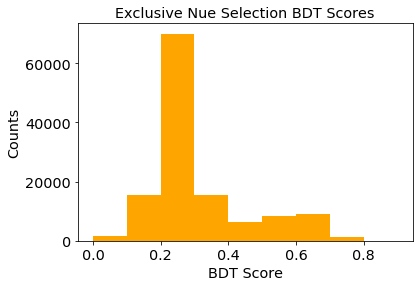

In [25]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [26]:

df_v = [nue_nue]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1


In [27]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS


if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'


In [28]:
#New categories

for i,df in enumerate(df_v):
            
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [29]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 63.07647295559603


In [30]:
test = np.nansum(datasets_bdt.query(NUE_SEL_QUERY + 'and is_signal==True')['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 53.65730794901259


In [31]:
test = np.nansum(datasets_bdt.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 53.65730794901259


In [32]:
#ENERGY - For pre plots
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         1.091233
1         1.021852
2         0.000000
3         1.479866
4         0.000000
            ...   
124423    0.000000
124424    1.644221
124425    0.000000
124426    0.462979
124427    0.000000
Name: reco_e, Length: 124428, dtype: float32
entry
0         1.091233
1         1.021852
2         0.000000
3         1.479866
4         0.000000
            ...   
124423    0.000000
124424    1.644221
124425    0.000000
124426    0.462979
124427    0.000000
Name: reco_e, Length: 124428, dtype: float32


In [32]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])

#LEPTON
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])
#------
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])


entry
0         0.000000
1         1.786124
2         1.418607
3         1.246518
4         1.054967
            ...   
127758    0.807293
127759    0.572803
127760    0.000000
127761    0.000000
127762    2.329041
Name: reco_e, Length: 127763, dtype: float32
entry
0         0.000000
1         1.786124
2         1.418607
3         1.246518
4         1.054967
            ...   
127758    0.807293
127759    0.572803
127760    0.000000
127761    0.000000
127762    2.329041
Name: reco_e, Length: 127763, dtype: float32
entry
0        -0.906756
1         0.923636
2         0.987200
3         0.911294
4         0.836977
            ...   
127758    0.726773
127759    0.973092
127760    0.974229
127761   -0.906756
127762    0.977648
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 127763, dtype: float64
entry
0        -0.906756
1         0.923636
2         0.987200
3         0.911294
4         0.836977
            ...   
127758    0.726773
127759    0.973092
127760    0.974229
127761   -0.9067

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  124428
n_events/2 here =  24885.0

1.0
1
124428
{'nue_nue': 1}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.01751832 0.01703665 0.01156542 ... 0.01513592 0.02143033 0.02149897]
current_total  123.91064516404982
123.910645164049824984431324992328882217407226562500000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  123.91064516404982
123.9

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


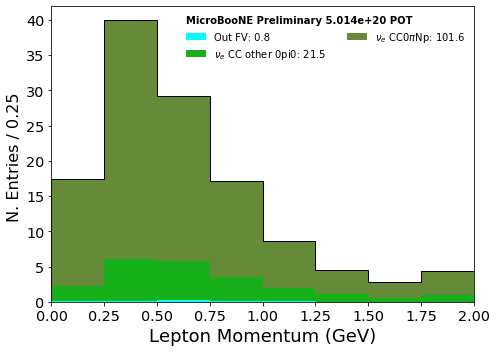

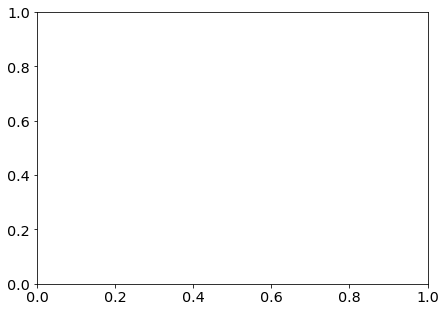

In [98]:
#WHAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    # NUE
    weights = { #full sample mc = 0.38
                #"nue_nue"  : nueratio  * SPLIT * scaling
                "nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #SET UP PLOTS
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #noCut, PreCuts
    
    #THEN RUN NEW OVERFLOW
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        #query= "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX",
        genieweight = "totweight_data",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  124428
n_events/2 here =  24885.0

1.0
1
124428
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575and is_signal==True& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.88565   0.5846971 0.9407419 ... 1.1434569 1.0834242 1.0868943]
current_total  101.60557700164077
101.605577001640767775825224816799163818359375000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current

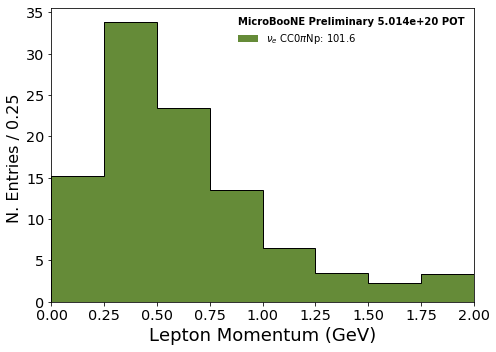

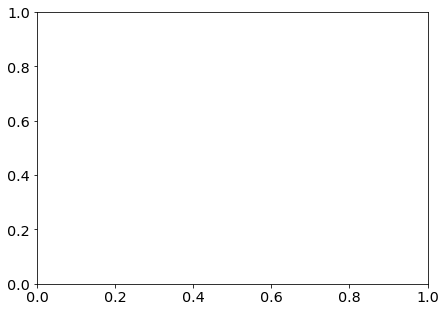

In [106]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
                #"nue_nue"   :  nue_nue['totweight_data']
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #SET UP PLOTS
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #noCut, PreCuts
    
    #THEN RUN NEW OVERFLOW
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUE_SEL_QUERY,
        #query = BDT_LOOSE_CUTS + " and is_signal == True",
        #query = "is_signal == True",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "totweight_data",
        #genieweight = "nslice",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


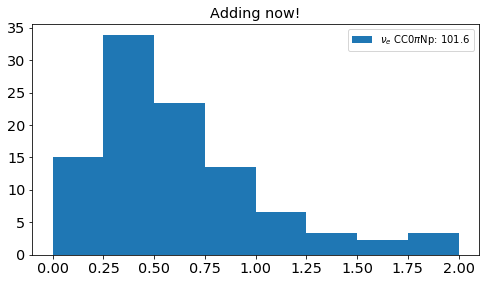

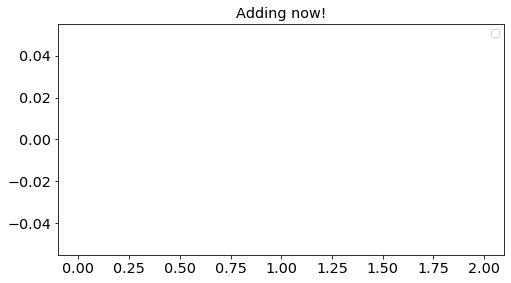

In [107]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0.04, 5.0])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [108]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

4628
4628


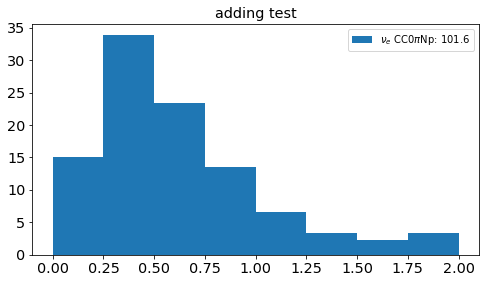

In [109]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}

labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0.0, 5.0])
#nue_ax1.set_ylim([0, 60])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 35])

print(len(varss_tot[0][1]))
print(len(weightss_tot[0][1]))

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()


#print('%.75f' % sum(nue_stacked[0]))
#print(nue_stacked[0])

In [110]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0 #2

nue_wanted_list = nue_stacked[0]
#nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

#2 for not signal, 0 for signal
#print(nue_wanted_list[0])
#print(sum(nue_wanted_list[0]))

#print('%.75f' % nue_wanted_list[9])

In [111]:
ending

'Jan19b'

In [112]:
#ending = "Jan19b_NoCut"
#ending = "Jan19b_PreCuts"
ending = "Jan19b"

In [113]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"


if isRun3 == False:
    if (is_selected == True):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
if isRun3 == True:
    if (is_selected == True):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')

### Stat Errors

In [122]:
# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Elec_asmuon_reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP_asmuon_reco"
    bins = np.arange(0, 2.25, 0.25)


for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(datasets_bdt.query(SIGNAL_NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[0.5178814238925264, 1.8405198720372047, 1.3022858081655118, 0.22306088846191705, 0.08556806178929847, 0.07464462883236334]


In [123]:

if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    

In [124]:
# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
    print(len(bins))
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Elec_asmuon_reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP_asmuon_reco"
    bins = np.arange(0, 2.25, 0.25)


for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(datasets_bdt.query(NOT_SIGNAL_NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

7
[0.07443924498637475, 0.4583335084893451, 0.21310419112363416, 0.08068247121244364, 0.025051003053553005, 0.02101149684385677]


In [125]:


if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
if isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    

### Sys Errors

In [33]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    
    weights = {
                #"nue_nue"  : nueratio  * SPLIT * scaling
                "nue_nue"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        #genieweight = "weightSplineTimesTuneTimesPPFX", 
        genieweight = "totweight_data", 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  127763
n_events/2 here =  63881.0

1.0
1
{'nue_nue': 1}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0      590   213   196   301   408   473   460  1089   703   689  ...   269   
1      778   858   891   934   739   857  1011   905   910   881  ...   890   
2      662   534   376   812  1334   693   356  1150   623  1311  ...   632   
3     1079  1261  1006  1099   872   897 

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
9
8
[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[8.232589647506313, 22.669559931680027, 15.426562113685796, 8.105847485430877, 4.079946121237905, 1.973924181755946, 1.0360516531962878, 1.5519918211028796]
8
[ 8.23258965 22.66955993 15.42656211  8.10584749  4.07994612  1.97392418
  1.03605165  1.55199182]


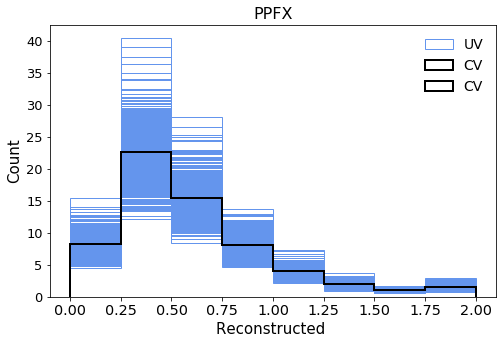

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
9
8
[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
8
[0. 0. 0. 0. 0. 0. 0. 0.]


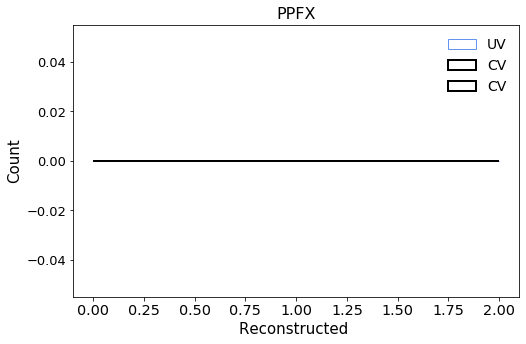

In [35]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bins)
    print(len(bins))
    print(len(bin_centers))
    print(bin_centers)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            print(detvar_dicts[j][variation])
            print(len(detvar_dicts[j][variation]))
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [36]:
#will need to edit this if batching

nue_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])
print(nue_nue_ppfx_detvar_dict)


if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

          CV          0          1          2          3          4  \
0   8.232590   8.903080   5.677741   5.772135   7.190956   6.634432   
1  22.669560  23.235530  15.212789  14.971134  19.266004  18.605327   
2  15.426562  15.894545  10.958068   9.998591  13.983549  13.057322   
3   8.105847   8.742803   5.717808   5.287548   7.416078   7.359531   
4   4.079946   4.173597   2.809596   2.618375   3.497339   3.408135   
5   1.973924   1.969720   1.305126   1.155669   1.718661   1.662978   
6   1.036052   0.992276   0.765956   0.640459   0.916390   0.842671   
7   1.551992   1.664623   1.079201   0.967548   1.406817   1.548970   

           5          6          7          8  ...        490        491  \
0   7.769346   6.778849   9.134297   9.131532  ...   9.045579   8.794484   
1  21.105941  18.114001  25.020090  25.101900  ...  25.763264  24.181837   
2  14.567458  12.342241  18.007170  17.405183  ...  17.494256  16.649068   
3   7.824305   6.643300   9.092304   9.113987  ...   9.2

In [37]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [41]:
if isRun3 == False: 
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')
        

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')
        print(type(final_ns_nue_nue_ppfx[0]))
        
        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        print(final_ncvs_nue_nue_ppfx)

        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"): 
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')

<class 'numpy.ndarray'>
[ 8.23258965 22.66955993 15.42656211  8.10584749  4.07994612  1.97392418
  1.03605165  1.55199182]


In [171]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    
    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428
n_events/2 here =  62214.0

1.0
1
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0      617   359   186  1283   411   521   988   557  1189   538  ...   799   
1      767   649   994  1010  1059   903   939   374   760  1770  ...  1080   
2     1207  1086   949  1188   998  1253  1098  1145  1193  1204  ...  1188   
3     1403  2247  1947   630   308   936   531 

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[17.19144058 58.31305313 29.98600006 10.39725494  4.43341827  3.58947754]


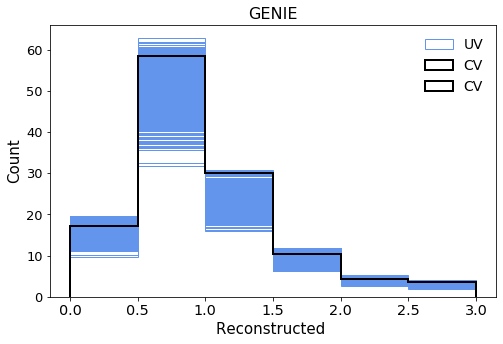

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


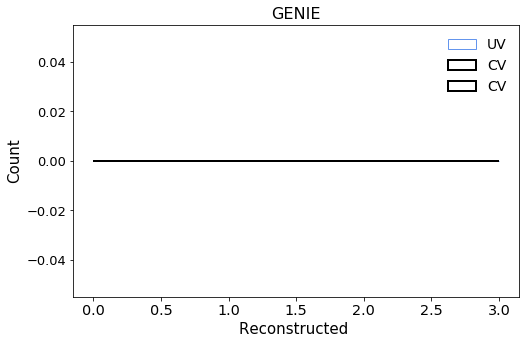

In [172]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [173]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')  
    elif (variable == "Angle"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Lepton"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv') 

In [174]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [175]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################
        #typo missing _
        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [176]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#this time = nevents
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    
    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428
n_events/2 here =  62214.0
weightsReint
1.0
1
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1141  1360   997   974  1351  1007   856  1080   793  1149  ...  1001   
1      877  1228  1399  1089   734  1500  1009   647  1418   938  ...   777   
2      986   958  1028  1001   980   991   984   989  1017   992  ...   975   
3     1096  1343   519  1006  1023 

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[17.19144058 58.31305313 29.98600006 10.39725494  4.43341827  3.58947754]


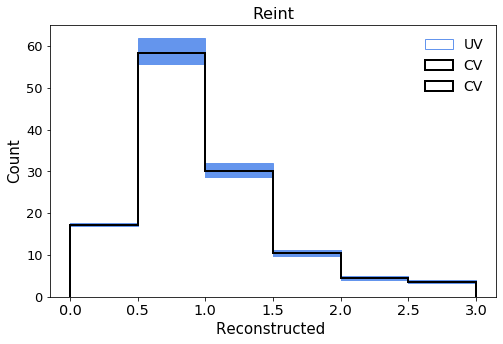

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


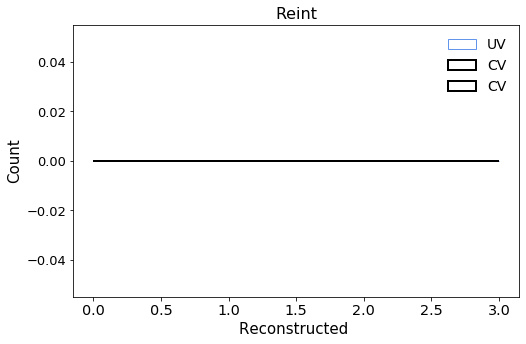

In [177]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
        
        
    print(bin_centers)
    print(bins)


    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [178]:
#will need to edit this if batching

nue_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Lepton"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [179]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)
print(final_ncvs_nue_nue_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)

[17.19144058 58.31305313 29.98600197 10.39725494  4.43341589  3.58948016]
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0     1141  1360   997   974  1351  1007   856  1080   793  1149  ...  1001   
1      877  1228  1399  1089   734  1500  1009   647  1418   938  ...   777   
2      986   958  1028  1001   980   991   984   989  1017   992  ...   975   
3     1096  1343   519  1006  1023  1137  1506  1122   887   982  ...  1470   
4      988   963  1024  1001   983   992   985   990  1014   993  ...   978   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
5727   984   951  1031  1002   976   990   983   987  1020   990  ...   972   
5728   973   922  1043  1004   957   986   983   980  1035   981  ...   963   
5729  1185  2029   826   769   896  1460   721   729  1171  1305  ...   879   
5730  1061  1205   707  1001  1034  1073  1235  1069   925  1000  ...  1233   
5731   975   927  1041  1003   960   987   982   981  103

In [180]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')

    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [181]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#was I out of it choosing batch sizes?!
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428
n_events/2 here =  62214.0
1.0
2
{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.019780185098979827}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tk

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


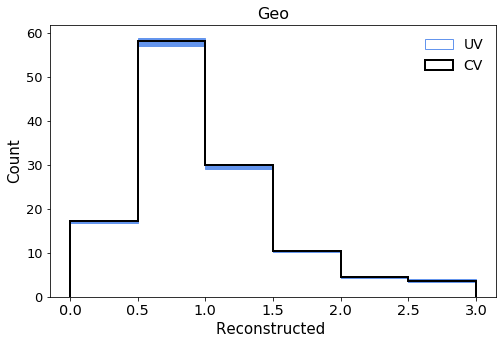

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


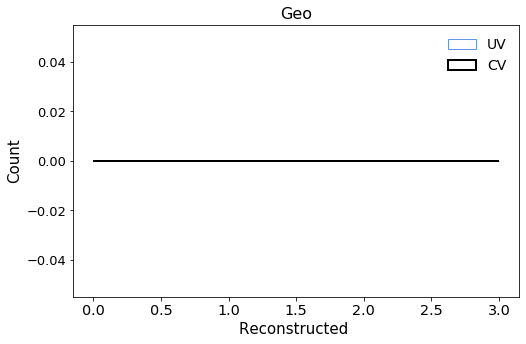

In [182]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
        
        
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [183]:
#will need to edit this if batching

nue_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [184]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [185]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):

        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')




## NUE_MC SAMPLE

In [5]:
import time
s = time.time()

# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/numi_run1_nu_overlay_fhc'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/numi_run3b_nu_overlay_rhc'    +ls.APPEND
        

#actually fetch datasets
nue_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt", "swtrig_pre",            
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_p","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc  = nue_mc.pandas.df(nue_variables + WEIGHTS + SYSTEMATICS + PPFX + nue_varMC, flatten=False)

#just prints out the time this cell takes
print("==============================")
s2 = time.time()
print ("time to run: ",s2-s)

['reco_nu_vtx_sce_x', 'shrsubclusters0', 'npion', 'reco_nu_vtx_sce_z', 'shr_tkfit_nhits_U', 'ccnc', 'proton_e', 'shr_energy_cali', 'nproton', 'elec_e', 'shr_distance', 'n_showers', 'trk_energy', 'shrmoliereavg', 'trkshrhitdist2', 'n_tracks', 'shrsubclusters1', 'shrsubclusters2', 'topological_score', 'tksh_angle', 'shr_tkfit_dedx_U', 'run', 'flash_time', 'shr_pz', 'shr_energy', 'sub', 'n_tracks_contained', 'shr_tkfit_dedx_Y', 'shr_tkfit_dedx_V', 'shr_phi', 'contained_fraction', 'trk_score_v', 'reco_nu_vtx_sce_y', 'shr_tkfit_nhits_Y', 'slnhits', 'evt', 'nu_pdg', 'shr_theta', 'npi0', 'trk_energy_tot', 'shr_px', 'shr_tkfit_nhits_V', 'hits_ratio', 'tksh_distance', 'shr_py', 'slnunhits', 'n_showers_contained', 'shr_tkfit_npoints', 'swtrig_pre', 'shr_score', 'nslice', 'CosmicIPAll3D', 'category', 'selected', 'shr_energy_tot_cali']
time to run:  1397.726312160492


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33978E21
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    overlay_pot =  1.98265e+21    

nue_mc['pot_scale'] = beamon_pot/overlay_pot

In [9]:
nue_mc['totweight_data'] = nue_mc['pot_scale']*nue_mc['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE

#This assumes the electron to be the leading shower

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon'] = np.arccos(df['shr_pz']/df['targetP_asmuon'] )
    #df['targetPhi_asmuon']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])

In [13]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    print(trk_energy_proton_v)
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel # this will be singular I think
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

[[] [] [1.004767 0.12017499 0.07016549] ... [0.28670606 0.18268651 0.15116628] [0.23678796 0.17143907 0.08350822] [0.5957372 0.14057478]]
time to run:  321.595338344574


In [14]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [15]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [16]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  6.7233240604400635


In [17]:
INTERCEPT = 0.0
SLOPE = 0.83

#df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [18]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [19]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [20]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(746172, 111)


In [23]:
datasets_bdt = nue_mc

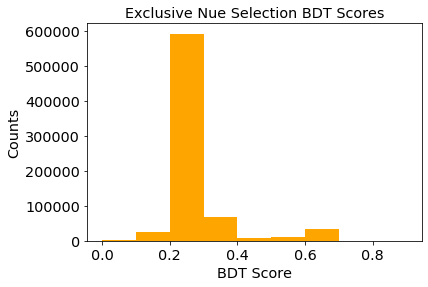

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [25]:

df_v = [nue_mc]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [26]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'


In [27]:
#New categories

for i,df in enumerate(df_v):

    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1) & (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [28]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(nue_mc.query(nueCC_query))))
len1 = len(nue_mc)

idx = nue_mc.query(nueCC_query).index
nue_mc.drop(idx, inplace=True)
len2 = len(nue_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))


# of nueCC in AV in overlay sample = 9872
# of nueCC in AV dropped in overlay = 9872


In [29]:
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY + "and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_mc.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

print("")

test = np.nansum(nue_mc.query("cosNu_Angle_Numi_Elec_asmuon_reco >-1.0 and cosNu_Angle_Numi_Elec_asmuon_reco <1.0")['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 32.03762409937198
total signal events = 32.03762409937198
total signal events = 0.0

total signal events = 183046.23340732433


In [30]:
#FOR SET UP PLOTS

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.000000
1         0.000000
2         0.031882
3         0.000000
4         0.216980
            ...   
746167    0.000000
746168    0.213190
746169    0.000000
746170    0.351129
746171    0.000000
Name: reco_e, Length: 736300, dtype: float32
entry
0         0.000000
1         0.000000
2         0.031882
3         0.000000
4         0.216980
            ...   
746167    0.000000
746168    0.213190
746169    0.000000
746170    0.351129
746171    0.000000
Name: reco_e, Length: 736300, dtype: float32


In [43]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness
###DON'T RUN FOR SET UP PLOTS###


#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])

#LEPTON
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])
#------
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])

entry
0         0.000000
1         0.000000
2         0.031882
3         0.000000
4         0.216980
            ...   
746167    0.000000
746168    0.213190
746169    0.000000
746170    0.351129
746171    0.000000
Name: reco_e, Length: 736300, dtype: float32
entry
0         0.000000
1         0.000000
2         0.031882
3         0.000000
4         0.216980
            ...   
746167    0.000000
746168    0.213190
746169    0.000000
746170    0.351129
746171    0.000000
Name: reco_e, Length: 736300, dtype: float32
entry
0        -0.906756
1        -0.906756
2         0.224283
3         0.974137
4         0.974641
            ...   
746167   -0.906756
746168    0.511502
746169    0.974608
746170   -0.718938
746171    0.973881
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 736300, dtype: float64
entry
0        -0.906756
1        -0.906756
2         0.224283
3         0.974137
4         0.974641
            ...   
746167   -0.906756
746168    0.511502
746169    0.974608
746170   -0.7189

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  736300

1.0
1
0
736300
{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_mc
--------------------------------------
current sample is:  nue_mc
current_total  32.037624099371975
32.037624099371974750738445436581969261169433593750000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  32.037624099371975
32.037624099371974750738445436581969261169433593750000000000000000000000000000
----------

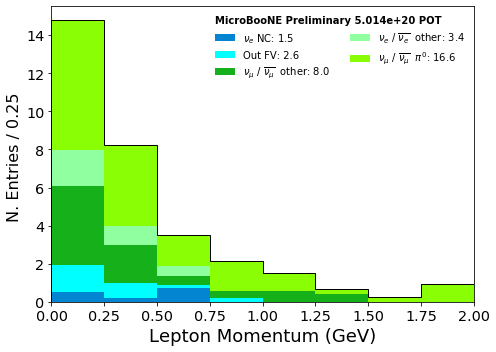

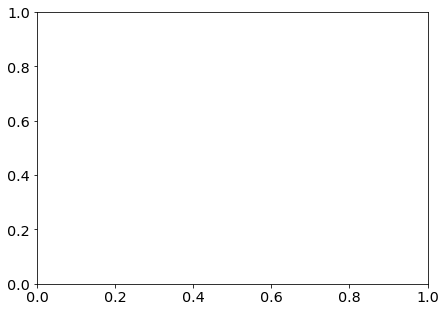

In [56]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/3.3))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]
    
    print(sample_set.shape[0])

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    # NU
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #RUN INTIAL OVERFLOW CUTS
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    
    #NOW RUN OVERFLOW CUTS
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= "",
        #query= BDT_LOOSE_CUTS,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


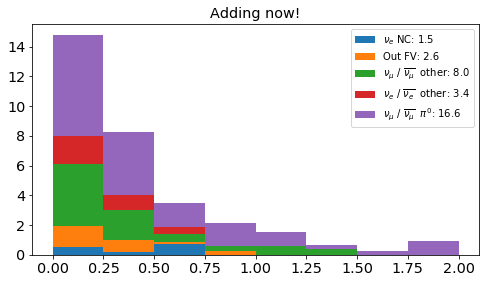

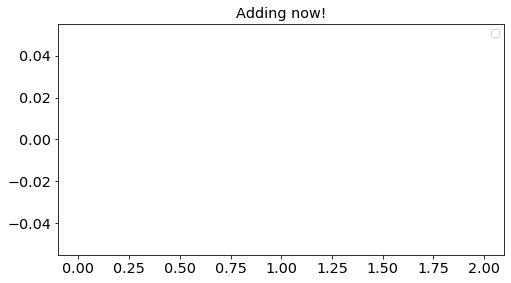

In [57]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [58]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

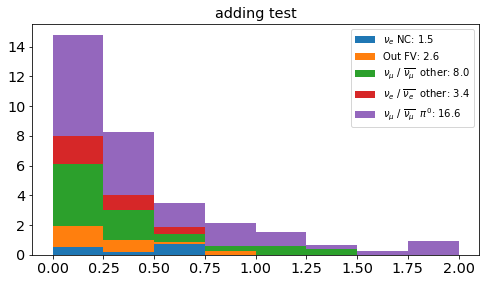

In [59]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 15])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 2])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [60]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

#print(nue_wanted_list)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [61]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#ending = "Jan19b_NoCut"
#ending = "Jan19b_PreCuts"
ending = "Jan19b"

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"


if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 ==True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')    

### Stat Errors

In [66]:
#nuemcstat

# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Elec_asmuon_reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP_asmuon_reco"
    bins = np.arange(0, 2.25, 0.25)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(datasets_bdt.query(NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[2.3132219175886024, 4.933925473269639, 0.7015931888599112, 0.7086976039024735, 0.06043704113940099, 0.3842155970533655]


In [67]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')


### Sys Errors

In [108]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        #query= "",
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  736300
n_events/2 here =  368150.0

1.0
1
{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0     982   490   318   491   652   782   917  1750  1073  1243  ...   444   
1    1555   484   494  1173  1035  1590   791   784   934  1673  ...  1254   
2     958  1358   696  1016  2302  1455  1048   525   743   127  ...   511   
3     751   189   188   462   439 

[ 9.07816792 15.70601559  3.03927231  2.62486267  0.24584007  1.34346581]


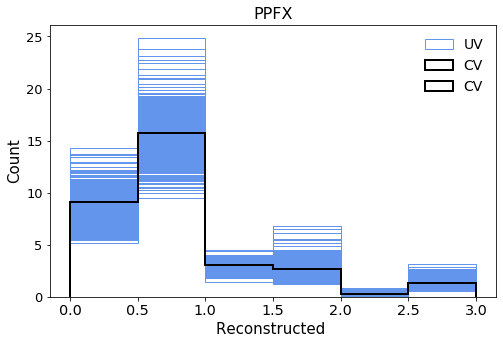

[0. 0. 0. 0. 0. 0.]


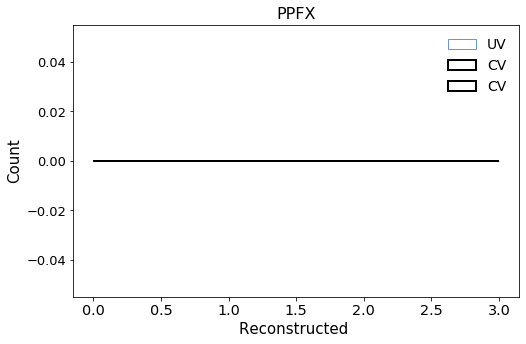

In [109]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/detsys_shr_energy_cali_fhc_intrinsic.pdf", 
    #            transparent=True, bbox_inches='tight')

    plt.show()

In [110]:
#will need to edit this if batching

nue_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_ppfx_detvar_dict.to_csv('nue_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [111]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [112]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):

        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):

        np.savetxt("nue_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('nue_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [113]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }  


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  736300
n_events/2 here =  368150.0

1.0
1
{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0     657   779   260  1096   407  1232   827  1868   626  1113  ...   782   
1     929   366   495  1142   939   468  1198   461  1226   399  ...   962   
2      99  1871  1021   372  1102  2035   745   643   899   516  ...   645   
3       1   502  2894   213   431 

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 9.07816792 15.70601559  3.03927231  2.62486267  0.24584007  1.34346581]


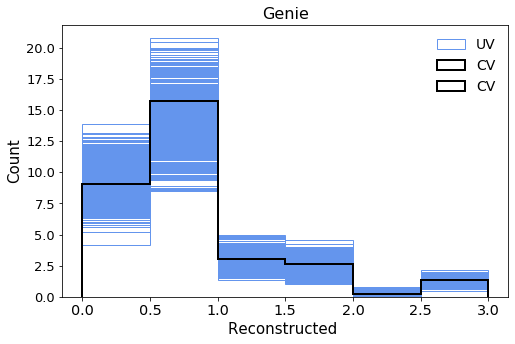

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


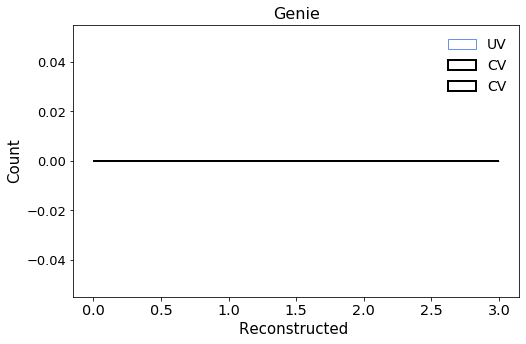

In [114]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0

    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [115]:
#will need to edit this if batching

nue_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_genie_detvar_dict.to_csv('nue_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [116]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_genie.append(sum(masterlist[a]))

final_ncvs_nue_mc_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)

In [117]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [118]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
#batch_size = 40000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  736300
n_events/2 here =  368150.0
weightsReint
1.0
1
{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
extra query added.
      0     1     2     3     4     5     6     7     8     9    ...  990  \
0     856   635  1241  1025   770   930   934   897  1224   893  ...  826   
1     988   965  1023  1001   984   993   986   991  1014   993  ...  979   
2     865   843  1135   405   945  1153  1151  1130  1025   830  ...  994   
3     996   820   987   92

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 9.07816792 15.70601559  3.03927231  2.62486267  0.24584007  1.34346581]


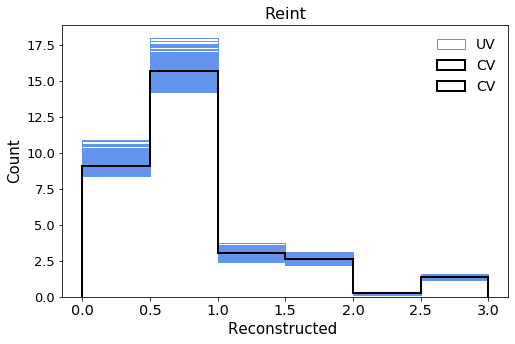

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


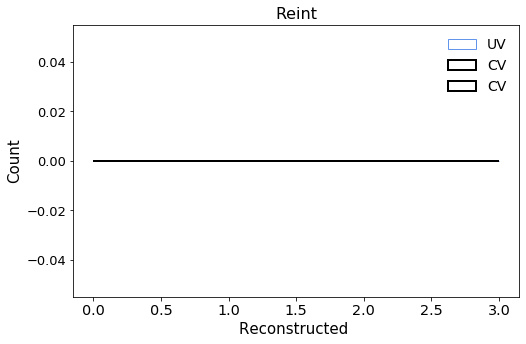

In [119]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [120]:
#will need to edit this if batching

nue_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_reint_detvar_dict.to_csv('nue_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [121]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_reint.append(sum(masterlist[a]))

final_ncvs_nue_mc_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [122]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [123]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
#batch_size = 20000
batch_size = n_events
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
        
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
 
    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  736300
n_events/2 here =  368150.0
1.0
2
{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_mc': 0.2528938541850554}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_d

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
dict_keys(['CV', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
[ 9.07816792 15.70601559  3.03927231  2.62486267  0.24584007  1.34346581]


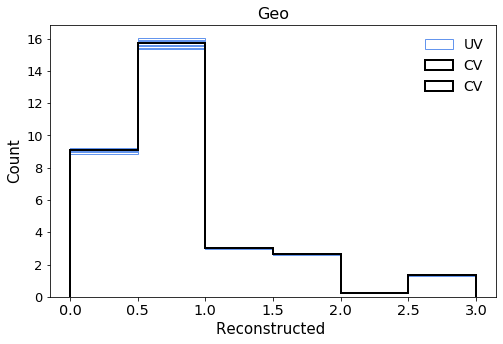

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
dict_keys(['CV'])
[0. 0. 0. 0. 0. 0.]


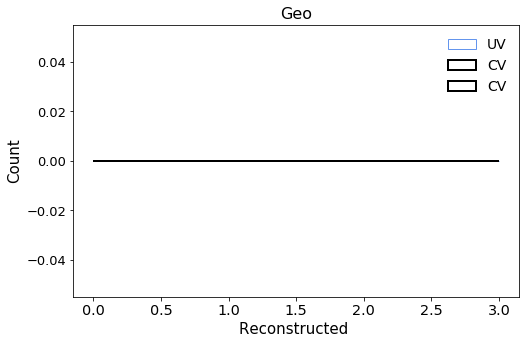

In [124]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 
    print(detvar_dicts[j].keys())


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                    weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [125]:
#will need to edit this if batching

nue_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')   
    elif (variable == "Angle"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_mc_geo_detvar_dict.to_csv('nue_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [126]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_geo.append(sum(masterlist[a]))

final_ncvs_nue_mc_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_mc_geo)):
    final_ns_nue_mc_geo[x] = np.concatenate((final_ns_nue_mc_geo[x][0], final_ns_nue_mc_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [127]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')

        

## NUE_DIRT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
#DRT  = 'neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
if isRun3 == False:
    DRT  = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'        +ls.APPEND
elif isRun3 == True:
    DRT  = 'neutrinoselection_filt_run3b_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt", "swtrig_pre",             
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS + PPFX, flatten=False)

['evt', 'shr_tkfit_nhits_V', 'proton_e', 'topological_score', 'sub', 'ccnc', 'n_tracks', 'shr_pz', 'shr_energy', 'flash_time', 'tksh_angle', 'reco_nu_vtx_sce_x', 'shr_tkfit_dedx_U', 'shrsubclusters2', 'nproton', 'shr_tkfit_nhits_Y', 'run', 'npion', 'nslice', 'hits_ratio', 'trk_energy', 'elec_e', 'shr_tkfit_dedx_Y', 'shrsubclusters0', 'shr_tkfit_dedx_V', 'n_showers_contained', 'n_tracks_contained', 'shr_py', 'shr_theta', 'shrsubclusters1', 'shr_phi', 'shrmoliereavg', 'tksh_distance', 'shr_energy_tot_cali', 'n_showers', 'category', 'swtrig_pre', 'nu_pdg', 'shr_energy_cali', 'contained_fraction', 'shr_distance', 'shr_tkfit_npoints', 'trkshrhitdist2', 'trk_energy_tot', 'shr_px', 'trk_score_v', 'CosmicIPAll3D', 'npi0', 'shr_score', 'reco_nu_vtx_sce_y', 'slnhits', 'reco_nu_vtx_sce_z', 'shr_tkfit_nhits_U', 'selected', 'slnunhits']


In [6]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [7]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [8]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.67392e+21
    scalingDRT = 0.65
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45 

nue_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [9]:
nue_dirt['totweight_data'] = nue_dirt['pot_scale']*nue_dirt['weightSplineTimesTuneTimesPPFX']

In [10]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [11]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  22.78026509284973


In [13]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  50.37802267074585


In [14]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [15]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']  

In [16]:
##Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  5.2641215324401855


In [17]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [18]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [19]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
   

Set up complete. Set up BDT for selection.

In [20]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [21]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [22]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(569506, 113)


In [23]:
datasets_bdt = nue_dirt

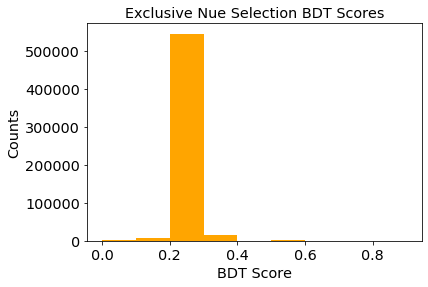

In [24]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [25]:

df_v = [nue_dirt]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [26]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS


if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
NOT_SIGNAL_NUE_SEL_QUERY += 'and is_signal==False'


In [27]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [28]:
test = np.nansum(nue_dirt.query(SIGNAL_NUE_SEL_QUERY )['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_dirt.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 0.09182816265566449


In [29]:
#RUN FOR PRE PLOTS

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
569501    0.0
569502    0.0
569503    0.0
569504    0.0
569505    0.0
Name: reco_e, Length: 569506, dtype: float32
entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
569501    0.0
569502    0.0
569503    0.0
569504    0.0
569505    0.0
Name: reco_e, Length: 569506, dtype: float32


In [44]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])

#LEPTON
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])
#------
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])


entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
569501    0.0
569502    0.0
569503    0.0
569504    0.0
569505    0.0
Name: reco_e, Length: 569506, dtype: float32
entry
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
569501    0.0
569502    0.0
569503    0.0
569504    0.0
569505    0.0
Name: reco_e, Length: 569506, dtype: float32
entry
0        -0.906756
1        -0.906756
2        -0.906756
3        -0.906756
4        -0.906756
            ...   
569501   -0.906756
569502   -0.906756
569503   -0.906756
569504   -0.906756
569505   -0.906756
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 569506, dtype: float64
entry
0        -0.906756
1        -0.906756
2        -0.906756
3        -0.906756
4        -0.906756
            ...   
569501   -0.906756
569502   -0.906756
569503   -0.906756
569504   -0.906756
569505   -0.906756
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 569506, dtype: float64
entry
0         

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_dirt
--------------------------------------
current sample is:  nue_dirt
current_total  0.09182816265566449
0.091828162655664485880535607975616585463285446166992187500000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.09182816265566449
0.0918281626556644858805356079756165854632854461669921875000000

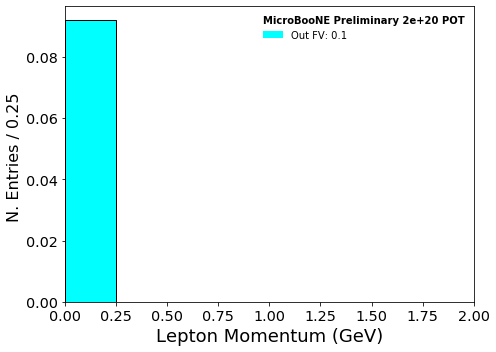

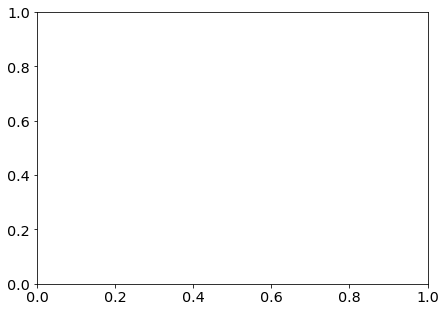

In [59]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # This is the POT scaling factor for dirt sample
        dirtratio = pot/1.67392e+21
        # We scale down the dirt (big uncertainties on this, there's a better data-MC agreement like this)
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NU
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        #query= "",
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


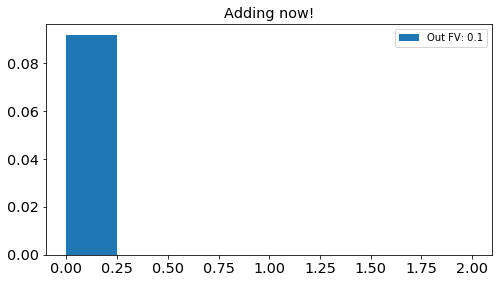

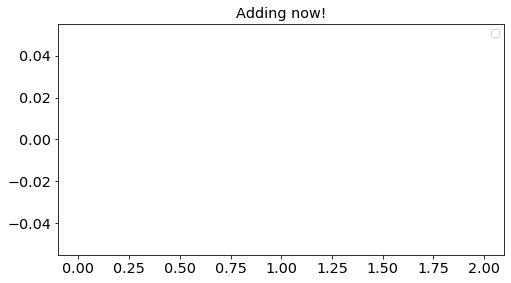

In [60]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [61]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

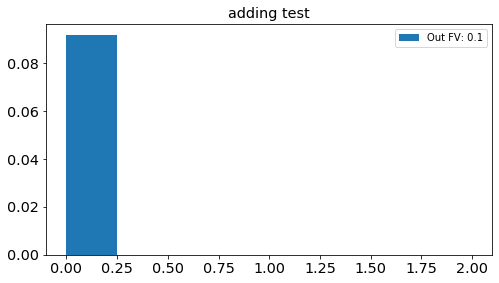

In [62]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 1.5])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.05])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [63]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [64]:
#ending = "Jan19b_NoCut"
#ending = "Jan19b_PreCuts"
ending = "Jan19b"

In [65]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"

if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Err

In [70]:
# sumw2 of the full event rate 
weight_stat_errs = []

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Elec_asmuon_reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP_asmuon_reco"
    bins = np.arange(0, 2.25, 0.25)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(datasets_bdt.query(NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[0.004296435854146879, 0, 0, 0, 0, 0, 0, 0]


In [71]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')


### Sys Errs

In [112]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
   0     1    2    3     4    5    6    7    8    9    ...   590   591   592  \
0  439  1079  642  481   497  104  138  547  297  132  ...  1000  1000  1000   
1  521  1148  445  264  1277  416  605  600  470  362  ...  1000  1000  1000   

    593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  
1  1

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.09182816 0.         0.         0.         0.         0.
 0.         0.        ]


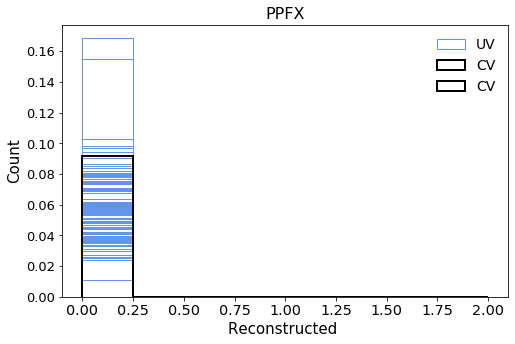

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


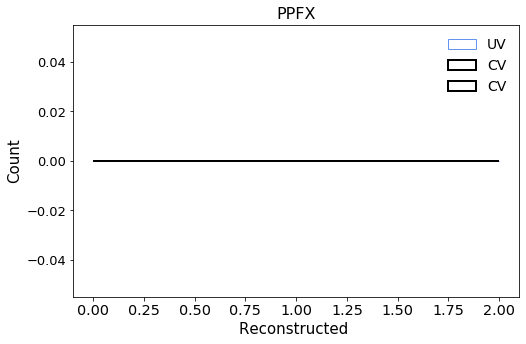

In [113]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [114]:
#will need to edit this if batching

nue_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_ppfx_detvar_dict.to_csv('nue_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [115]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [116]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('nue_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [117]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0

1.0
1
{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
    0     1     2    3    4    5    6     7    8    9    ...   590   591  \
0  1021  1078  1090  683  892  494  848  1023  396  772  ...  1000  1000   
1  1247  1350  1203  359  829  181  785  1209  207  725  ...  1000  1000   

    592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  
1  1

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.09182816 0.         0.         0.         0.         0.
 0.         0.        ]


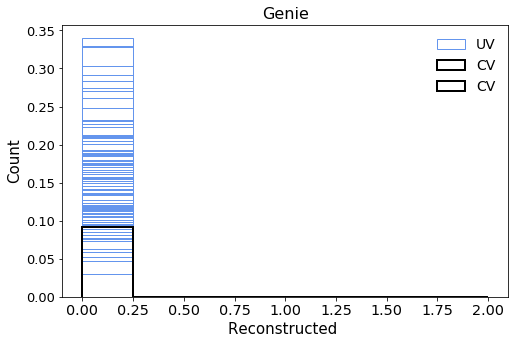

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


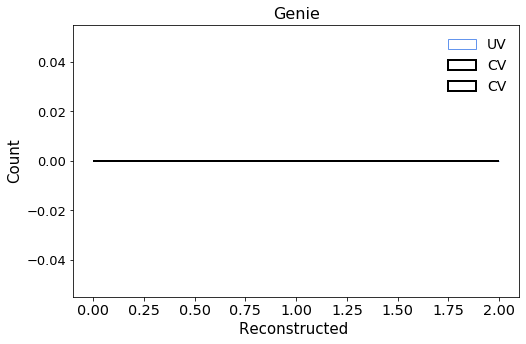

In [118]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [119]:
#will need to edit this if batching

nue_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_genie_detvar_dict.to_csv('nue_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [120]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_genie.append(sum(masterlist[a]))

final_ncvs_nue_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


    0     1     2    3    4    5    6     7    8    9    ...   590   591  \
0  1021  1078  1090  683  892  494  848  1023  396  772  ...  1000  1000   
1  1247  1350  1203  359  829  181  785  1209  207  725  ...  1000  1000   

    592   593   594   595   596   597   598   599  
0  1000  1000  1000  1000  1000  1000  1000  1000  
1  1000  1000  1000  1000  1000  1000  1000  1000  

[2 rows x 600 columns]
entry
493569    0.112762
534799    0.030118
Name: targetP_asmuon_reco, dtype: float32
entry
493569    0.077662
534799    0.077662
Name: weightSpline, dtype: float32


In [121]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [122]:
########### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
weightsReint
1.0
1
{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
    0     1     2     3     4     5     6     7     8     9    ...   990  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    991   992   993   994   995   996   997   998   999  
0  1000  1000  1000  1000  1000  1000 

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.09182816 0.         0.         0.         0.         0.
 0.         0.        ]


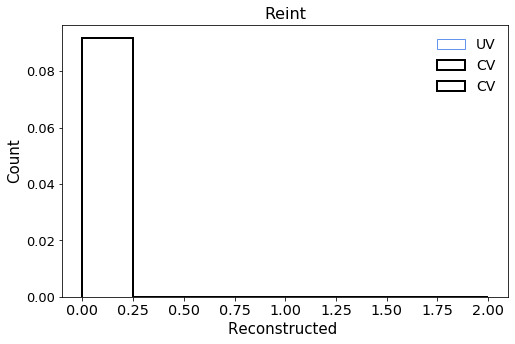

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


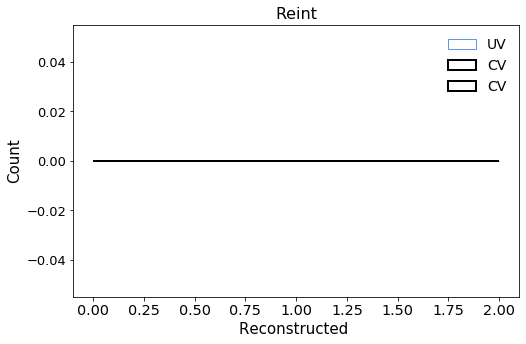

In [123]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)
    

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [124]:
#will need to edit this if batching

nue_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_reint_detvar_dict.to_csv('nue_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [125]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_reint.append(sum(masterlist[a]))

final_ncvs_nue_dirt_reint = sum(n_cv_tots)
print(final_ncvs_nue_dirt_reint)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)


[0.09182816 0.         0.         0.         0.         0.
 0.         0.        ]
    0     1     2     3     4     5     6     7     8     9    ...   990  \
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1  1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   

    991   992   993   994   995   996   997   998   999  
0  1000  1000  1000  1000  1000  1000  1000  1000  1000  
1  1000  1000  1000  1000  1000  1000  1000  1000  1000  

[2 rows x 1000 columns]
entry
493569    0.112762
534799    0.030118
Name: targetP_asmuon_reco, dtype: float32
entry
493569    0.039580
534799    0.052248
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [126]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [127]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUE_SEL_QUERY,
        currentsample = "nue_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",  #meaningless here
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  569506
n_events/2 here =  284753.0
1.0
2
{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.55& targetP_asmuon_reco <= 2 & targetP_asmuon_reco >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_dirt': 0.07766201491110687}
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and s

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.09182816 0.         0.         0.         0.         0.
 0.         0.        ]


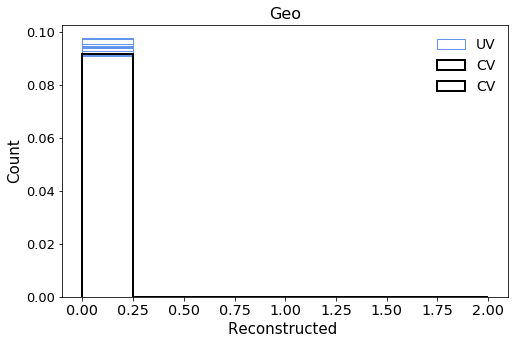

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


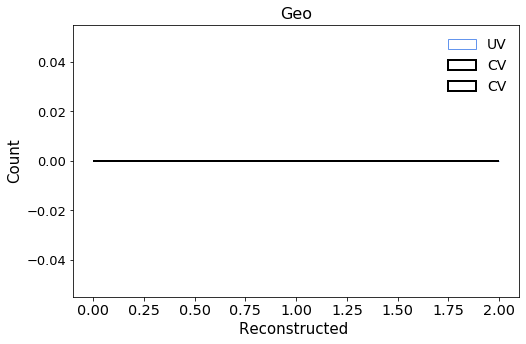

In [128]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [129]:
#will need to edit this if batching

nue_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_dirt_geo_detvar_dict.to_csv('nue_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [130]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_dirt_geo.append(sum(masterlist[a]))

final_ncvs_nue_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_dirt_geo)):
    final_ns_nue_dirt_geo[x] = np.concatenate((final_ns_nue_dirt_geo[x][0], final_ns_nue_dirt_geo[x][1]))
    
    
print(final_ns_nue_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
print(total_geo_df_splines)

[0.09483846 0.         0.         0.         0.         0.
 0.         0.         0.09450642 0.         0.         0.
 0.         0.         0.         0.        ]
entry
493569    0.039580
534799    0.052248
Name: weightSplineTimesTuneTimesPPFX, dtype: float32


In [131]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_nue_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



## NUE_EXT SAMPLE

In [46]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND    

#actually fetch datasets
nue_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_ext]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_ext  = nue_ext.pandas.df(nue_variables + nue_varMC, flatten=False)

['shr_energy_tot_cali', 'n_showers_contained', 'trk_energy', 'shr_tkfit_dedx_U', 'nu_pdg', 'shrsubclusters0', 'npi0', 'topological_score', 'nslice', 'shr_pz', 'tksh_distance', 'contained_fraction', 'shrsubclusters2', 'selected', 'elec_e', 'n_showers', 'trk_score_v', 'flash_time', 'shr_energy', 'category', 'shr_px', 'shr_tkfit_dedx_Y', 'trkshrhitdist2', 'n_tracks_contained', 'shr_tkfit_npoints', 'shr_score', 'npion', 'shr_distance', 'shr_theta', 'shr_energy_cali', 'shrsubclusters1', 'nproton', 'shr_py', 'proton_e', 'shr_tkfit_nhits_V', 'swtrig_pre', 'shr_tkfit_dedx_V', 'trk_energy_tot', 'reco_nu_vtx_sce_x', 'CosmicIPAll3D', 'n_tracks', 'shr_phi', 'sub', 'evt', 'shr_tkfit_nhits_Y', 'tksh_angle', 'slnhits', 'reco_nu_vtx_sce_z', 'slnunhits', 'reco_nu_vtx_sce_y', 'hits_ratio', 'run', 'shr_tkfit_nhits_U', 'shrmoliereavg', 'ccnc']


In [6]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)
df_v = [nue_ext]


if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98


nue_ext['pot_scale'] = extratio * scalingEXT

In [7]:
nue_ext['totweight_data'] = nue_ext['pot_scale']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_ext]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    #puppa_shw = []
    #puppa_prt = [] 
    #puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        #N_recoShowers = 0
        #N_recoProtons = 0
        #N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            #protonCut  = (passPIDCut & passTrkCut) 
            #muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            #N_obj         = len(passTrkCut)
            #N_recoTrks    = np.count_nonzero(passTrkCut)
            #N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            #N_recoProtons = np.count_nonzero(protonCut)
            #N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        #puppa_shw.append(N_recoShowers)    
        #puppa_prt.append(N_recoProtons)
        #puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    #df['N_recoShowers']   = puppa_shw
    #df['N_recoProtons']   = puppa_prt
    #df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    #df['protonenergy']    = trk_energy_proton_sel
    #df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    #df['protontheta']  = trk_theta_proton_sel
    #df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
#for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
#    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  88.08978033065796


In [11]:
#nue_ext.query("swtrig_pre==1 and nslice==1 and contained_fraction>0.9 \
#and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04", inplace=True)

In [12]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
df_v = [nue_ext]
import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  133.39353561401367


In [11]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [12]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [13]:
##Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  28.60262632369995


In [14]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_ext]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]
    
# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    #df["extdata"] = np.zeros_like(df["shr_energy"])
nue_ext["extdata"] = np.ones_like(nue_ext["shr_energy"])

In [15]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts

df_v = [nue_ext]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.359
        
#BDT 

Set up complete. Set up BDT for selection.

In [16]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [17]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')    

In [18]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_ext]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(3211097, 91)


In [19]:
datasets_bdt = nue_ext

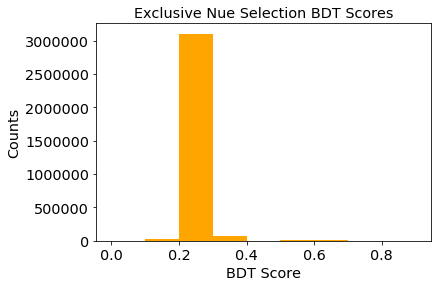

In [20]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [21]:
df_v = [nue_ext]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [22]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS

#No true selection here as this is data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [23]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [24]:
test = np.nansum(nue_ext.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_ext.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 0.0
total signal events = 4.324746883357073


In [25]:
##FOR SET UP PLOTS

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3211092    0.0
3211093    0.0
3211094    0.0
3211095    0.0
3211096    0.0
Name: reco_e, Length: 3211097, dtype: float32
entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3211092    0.0
3211093    0.0
3211094    0.0
3211095    0.0
3211096    0.0
Name: reco_e, Length: 3211097, dtype: float32


In [41]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])

#LEPTON
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])
#------
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])

entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3211092    0.0
3211093    0.0
3211094    0.0
3211095    0.0
3211096    0.0
Name: reco_e, Length: 3211097, dtype: float32
entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3211092    0.0
3211093    0.0
3211094    0.0
3211095    0.0
3211096    0.0
Name: reco_e, Length: 3211097, dtype: float32
entry
0         -0.906756
1         -0.906756
2         -0.906756
3         -0.906756
4          0.974679
             ...   
3211092   -0.906756
3211093   -0.906756
3211094    0.974588
3211095   -0.906756
3211096    0.974679
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 3211097, dtype: float64
entry
0         -0.906756
1         -0.906756
2         -0.906756
3         -0.906756
4          0.974679
             ...   
3211092   -0.906756
3211093   -0.906756
3211094    0.974588
3211095   -0.906756
3211096    0.974679
Name: cosNu_Angle_Numi_Elec_asmuon_reco, 

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

n_events here =  3211097
n_events/2 here =  1605548.0

1.0
1
{'ext': 0.3089104916683624}
 reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_ext
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 991867.1056363113
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
current_total_hist  [0. 0. 0. 0. 0. 0.]
0.0
n_ext  [9.85875169e+05 5.25024272e+03 5.02906280e+02 1.36229527e+02
 6.73424872e+01 3.52157961e+01]


No handles with labels found to put in legend.



Returning
{'ext': 0.3089104916683624}
 reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_ext
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
total after ext 0.0
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
current_total_split  []
current_total_hist  [0. 0. 0. 0. 0. 0.]
0.0
n_ext  [0. 0. 0. 0. 0. 0.]

Returning


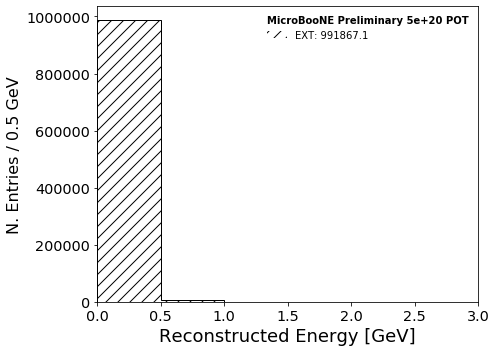

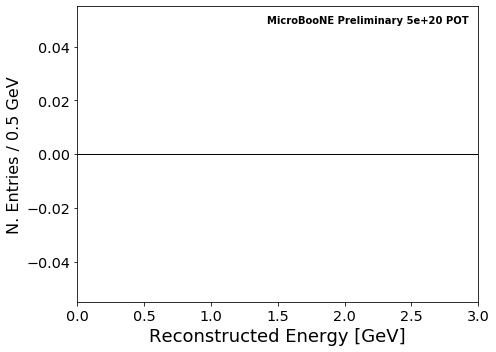

In [26]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_ext.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
#batch_size = n_events
batch_size = n_events
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_ext.iloc[start:end]

    samples = {
        "nue_ext": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
        extratio  = 5268051/9199232.74 #partial file: 2347745.0/4015961.99
        # We scale down the EXT to account for neutrino occupancy
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    

    # NU
    weights = { #full sample mc = 0.38  
                "ext" : extratio * SPLIT * scalingEXT, #set0 
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        #query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        query= "",
        currentsample = "nue_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


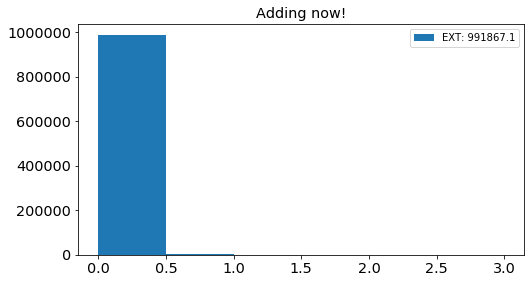

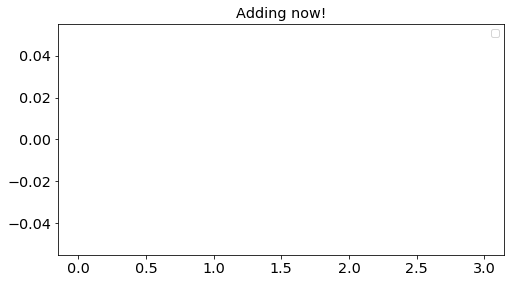

In [27]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()


In [28]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

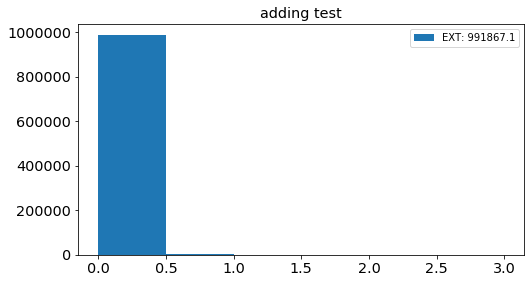

In [29]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 4])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 0.8])

nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [64]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 2

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [30]:
ending = "Jan19_NoCut"
#ending = "Jan19_PreCuts"
#ending = "Jan19"

In [31]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Errs

[1.47050109 1.47050109 0.         0.         0.         0.        ]


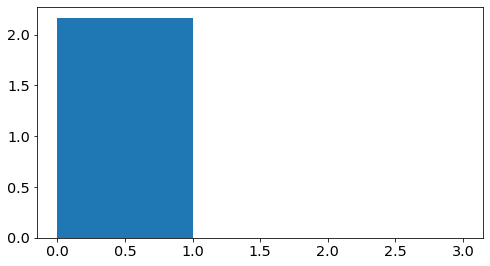

In [67]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 4])


nue_stacked = nue_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


nue_ext_stat_errs = np.sqrt(nue_stacked[0])

print(nue_ext_stat_errs)

In [68]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   nue_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    
        

## NUE_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND    

#actually fetch datasets
nue_data = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_data]

nue_variables = ["run", "sub", "evt", "swtrig_pre",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0", "proton_e", "elec_e",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'shr_px', 'shr_py', 'shr_pz']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_data = nue_data.pandas.df(nue_variables + nue_varMC , flatten=False)

['nu_pdg', 'shr_tkfit_nhits_V', 'shr_tkfit_npoints', 'slnhits', 'reco_nu_vtx_sce_z', 'tksh_distance', 'shr_distance', 'n_tracks', 'shr_phi', 'proton_e', 'shr_pz', 'shrsubclusters0', 'run', 'category', 'trk_energy_tot', 'nproton', 'CosmicIPAll3D', 'n_tracks_contained', 'reco_nu_vtx_sce_y', 'contained_fraction', 'shr_tkfit_dedx_Y', 'n_showers_contained', 'shrsubclusters1', 'shr_tkfit_dedx_U', 'reco_nu_vtx_sce_x', 'shr_energy', 'topological_score', 'selected', 'shrmoliereavg', 'n_showers', 'shrsubclusters2', 'ccnc', 'tksh_angle', 'trk_score_v', 'evt', 'shr_energy_cali', 'shr_energy_tot_cali', 'shr_tkfit_nhits_Y', 'nslice', 'shr_tkfit_nhits_U', 'flash_time', 'slnunhits', 'shr_py', 'npi0', 'shr_score', 'hits_ratio', 'swtrig_pre', 'shr_px', 'shr_theta', 'trkshrhitdist2', 'elec_e', 'npion', 'trk_energy', 'sub', 'shr_tkfit_dedx_V']


In [6]:
nue_data['pot_scale'] = [1 for x in range(len(nue_data))]

In [7]:
nue_data['totweight_data'] = nue_data['pot_scale']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#RECO VARIABLE
#This assumes the electron to be the leading shower
df_v = [nue_data]

import time
s = time.time()

for i,df in enumerate(df_v):
    df['targetP_asmuon_reco']     = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'] + df['shr_pz']*df['shr_pz'])
    #df['targetPt_asmuon_reco']    = np.sqrt(df['shr_px']*df['shr_px'] + df['shr_py']*df['shr_py'])
    #df['targetTheta_asmuon_reco'] = np.arccos(df['shr_pz']/df['targetP_asmuon_reco'] )
    #df['targetPhi_asmuon_reco']   = np.arctan2(df['shr_py'],df['shr_px'])
    df['nu_Angle_Numi_Elec_asmuon_reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_reco'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_reco'])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  41.63064098358154


In [11]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_data]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  90.75604844093323


In [12]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [13]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']

In [14]:
##Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  9.453694820404053


In [15]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_data]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"]+ df["proton_total_KE"]

# and a way to filter out data
for i,df in enumerate(df_v):
    #df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])
nue_data["bnbdata"] = np.ones_like(nue_data["shr_energy"])


Set up complete. Now on to BDT.

In [16]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"


BDT_PRE_QUERY = 'swtrig_pre==1 and nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 
    
BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [17]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})

if isRun3 == False:
    bdt_model.load_model('/home/alex/NuMI/bdt_FHC_may2022_subset.model')
elif isRun3 == True:
    bdt_model.load_model('/home/alex/NuMI/bdt_RHC_may2022_subset.model')
    

In [18]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_data]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(1104349, 100)


In [19]:
datasets_bdt = nue_data

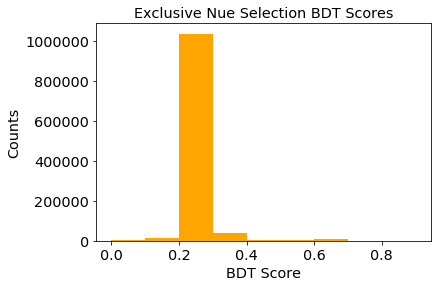

In [20]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [21]:
df_v = [nue_data]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1


In [22]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS

#No truth selection as this data

if isRun3 == False:
    NUE_SEL_QUERY += ' and BDT_score > 0.55'
elif isRun3 == True:
    NUE_SEL_QUERY += ' and BDT_score > 0.575'    

SIGNAL_NUE_SEL_QUERY = NUE_SEL_QUERY
SIGNAL_NUE_SEL_QUERY += 'and is_signal==True'

In [23]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)& (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [24]:
test = np.nansum(nue_data.query(SIGNAL_NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(nue_data.query(NUE_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0
total signal events = 163


In [25]:
##FOR PRE SCALE PLOTS

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1104344    0.0
1104345    0.0
1104346    0.0
1104347    0.0
1104348    0.0
Name: reco_e, Length: 1104349, dtype: float32
entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1104344    0.0
1104345    0.0
1104346    0.0
1104347    0.0
1104348    0.0
Name: reco_e, Length: 1104349, dtype: float32


In [38]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon_reco"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon_reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon_reco"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon_reco"])

#LEPTON
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])
#------
tmp = df["targetP_asmuon_reco"].copy()
mask = (df["targetP_asmuon_reco"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon_reco"] = tmp
print(df["targetP_asmuon_reco"])

entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1104344    0.0
1104345    0.0
1104346    0.0
1104347    0.0
1104348    0.0
Name: reco_e, Length: 1104349, dtype: float32
entry
0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1104344    0.0
1104345    0.0
1104346    0.0
1104347    0.0
1104348    0.0
Name: reco_e, Length: 1104349, dtype: float32
entry
0         -0.906756
1         -0.906756
2         -0.906756
3         -0.906756
4         -0.906756
             ...   
1104344   -0.906756
1104345   -0.906756
1104346   -0.906756
1104347   -0.906756
1104348   -0.906756
Name: cosNu_Angle_Numi_Elec_asmuon_reco, Length: 1104349, dtype: float64
entry
0         -0.906756
1         -0.906756
2         -0.906756
3         -0.906756
4         -0.906756
             ...   
1104344   -0.906756
1104345   -0.906756
1104346   -0.906756
1104347   -0.906756
1104348   -0.906756
Name: cosNu_Angle_Numi_Elec_asmuon_reco, 

Now apply the selection, looking at the plots produced with each stage.

This only has the BDT stage, so we can move on to looking at variables. 

No handles with labels found to put in legend.


n_events here =  1104349
n_events/2 here =  552174.0

1.0
1
swtrig_pre==1 and nslice==1 and 10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026 and contained_fraction>0.9 and n_showers_contained==1 and n_tracks_contained>0 and trk_energy>0.04 and shr_score<0.3 and shrmoliereavg<15 and shr_tkfit_dedx_Y<7 and trkpid<0.35 and tksh_distance<12 and BDT_score > 0.575& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_data
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

cu

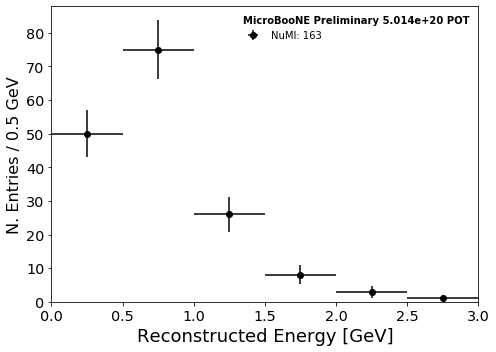

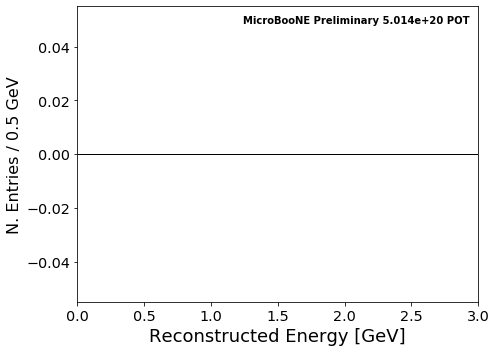

In [51]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_data.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
#batch_size = 40000
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_data.iloc[start:end]

    samples = {
        "nue_data": sample_set 
    }

    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"
    
    
    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon_reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon_reco',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUE_SEL_QUERY,
        #query= BDT_LOOSE_CUTS,
        #query= "",
        currentsample = "nue_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

[array([50, 75, 26,  8,  3,  1]), array([0, 0, 0, 0, 0, 0])]


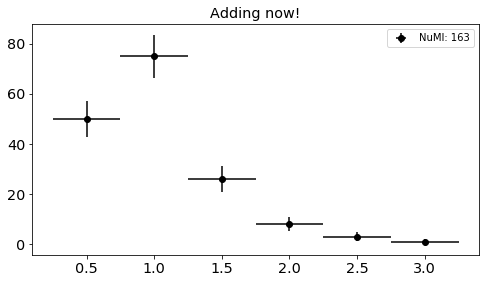

In [52]:
from matplotlib import gridspec

#for i in range(int(n_events/batch_size)+1):
for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    
    current_bincenters =  np.arange(0.5, 3.5, 0.5)  #energy
    current_bin_size = 0.5
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)  #Angle
    #current_bin_size = 0.2
    #current_bincenters =  np.arange(0.125, 2.125, 0.25)  #lepton
    #current_bin_size = 0.25
    
    print(varss)
    
    nue_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [53]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[7.07106781 8.66025404 5.09901951 2.82842712 1.73205081 1.        ]


[50 75 26  8  3  1]


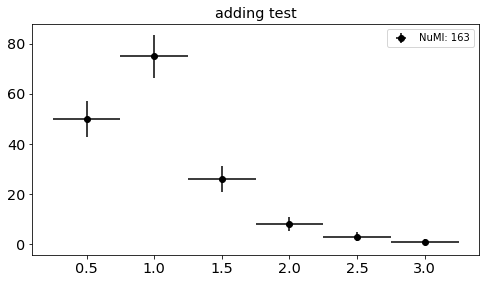

In [54]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = labss

nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 150])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 33])

print(varss_tot)

nue_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [55]:
#ending = "Jan19_NoCut"
#ending = "Jan19_PreCuts"
ending = "Jan19"

In [56]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    #######leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
    

## NUMU_MC SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NU   = '/numi_run1_nu_overlay_fhc'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/numi_run3b_nu_overlay_rhc'    +ls.APPEND 

#actually fetch datasets
numu_mc  = uproot.open(ls.ntuple_path+NU+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_mc]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", #"trk_pfp_id",
        "category", "ccnc", "swtrig_pre", "trk_len_v",
        "run","sub","evt", "hits_ratio",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance", "n_tracks_contained",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['swtrig_pre', '_opfilter_pe_veto', 'tksh_distance', 'slpdg', 'reco_nu_vtx_sce_x', 'shr_tkfit_dedx_Y', 'ccnc', 'reco_nu_vtx_sce_z', 'backtracked_pdg', 'hits_ratio', 'slnunhits', '_opfilter_pe_beam', 'trk_range_muon_mom_v', 'reco_nu_vtx_y', 'reco_nu_vtx_sce_y', 'muon_e', 'reco_e', 'pi0truth_elec_etot', 'nproton', 'category', 'evnunhits', 'trk_len_v', 'run', 'reco_nu_vtx_x', 'proton_e', 'pi0_e', 'sub', 'trk_energy_tot', 'nu_pdg', 'pion_e', 'trk_sce_end_x_v', 'slclustfrac', 'true_e_visible', 'trk_llr_pid_score_v', 'nmuon', 'CosmicIPAll3D', 'isVtxInFiducial', 'trk_sce_end_z_v', 'trk_energy_muon', 'trk_phi', 'contained_fraction', 'reco_nu_vtx_z', 'nslice', 'trk_sce_start_x_v', 'npi0', 'elec_e', 'n_showers_contained', 'n_tracks_contained', 'CosmicIP', 'interaction', 'npion', 'trk_sce_end_y_v', 'topological_score', 'CosmicDirAll3D', 'evt', 'slnhits', 'trk_score_v', 'shr_energy_tot_cali', 'trk_theta', 'flash_pe', 'trk_mcs_muon_mom_v']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#approx 25 min run time

trk_llr_pid_v  [[] [] [0.9866963 0.44418675 0.106284544] ... [0.749995 -0.7666651 0.5403374] [-0.8889313 0.63075006 0.036387682] [0.94489354 0.71762836]]
trk_score_v  [[] [] [1.0 0.01982896 0.14982662] ... [0.06810278 0.9277744 0.06486071] [0.96802574 0.06989831 0.096215084] [0.9999674 0.7959594]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
runtime =  1763.0644311904907


In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:

numu_mc.query("nu_e > 0 and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3", inplace=True)

In [9]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  19.543800115585327


In [10]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [11]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [12]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33978E21
elif isRun3 == True:
    beamon_pot = 5.014E20
    overlay_pot =  1.98265e+21    

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [13]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['weightSplineTimesTuneTimesPPFX']
print(numu_mc['totweight_data'])

entry
0         0.243116
1         0.148085
2         0.236625
3         0.243992
4         0.211369
            ...   
746167    0.112418
746168    0.243576
746169    0.124258
746170    0.246421
746171    0.308136
Name: totweight_data, Length: 746172, dtype: float64


In [14]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [15]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_4976/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  42.890591859817505


In [16]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [17]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [18]:
#RECO VARIABLE

s = time.time()
df_v = [numu_mc]

#use first value - from looking at the trk_start and nu_reco_vtx values, this should be the muon
for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)

KeyboardInterrupt: 

In [20]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [21]:
numu_mc["mc_pdg"]

entry
215                                 [13, 2212, 211, 2212]
285                            [13, -211, 211, 111, 2212]
719                                      [13, 2112, 2212]
775                                            [13, 2212]
951                                            [13, 2212]
                               ...                       
745140    [-13, 2112, -211, -211, 2212, 2212, 2212, -211]
745206                                         [13, 2212]
745280                      [-13, 2212, -211, 2112, 2212]
745448                                         [13, 2212]
745630                 [13, 2212, 2112, 2212, 2212, 2212]
Name: mc_pdg, Length: 5781, dtype: object

In [19]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046
df_v = [numu_mc]

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  6.9696033000946045


In [20]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [21]:
numu_mc   = numu_mc.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
#Comment out for pre cuts
#for i,df in enumerate(dfmc_v):
#    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
#    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Set up complete. 

In [22]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(numu_mc.query(nueCC_query))))
len1 = len(numu_mc)

idx = numu_mc.query(nueCC_query).index
numu_mc.drop(idx, inplace=True)
len2 = len(numu_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))

# of nueCC in AV in overlay sample = 9872
# of nueCC in AV dropped in overlay = 9872


In [23]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_mc"  : numu_mc
}


if isRun3 == False:
    pot =  2e+20 
    mcratio   = pot/2.33978e+21
elif isRun3 == True:
    pot =  5.014e20
    mcratio  = pot/1.98265e+21
        

SPLIT = 1.0
scaling = 1

weights = { "numu_mc"  : mcratio  * SPLIT * scaling  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_mc': 0.2528938541850554}


In [24]:


dfmc_v = [numu_mc]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1
    


In [25]:
#New categories

for i,df in enumerate(dfmc_v):

    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9

    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False), True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [200]:
"""
and reco_nu_vtx_sce_x > 10 and reco_nu_vtx_sce_x < 250 \
and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 1010  \
"""


NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score > 0.3"


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += ' and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += ' and is_signal==False'

In [201]:
test_total = np.nansum(numu_mc.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test_total))
test = np.nansum(numu_mc.query(NUMU_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0 & -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8)")['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 2120.2084231047675
total signal events = 2120.2084231047675


In [202]:
test_signal = np.nansum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test_signal))
test = np.nansum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY + " and ~(abs(nu_pdg) == 12 & ccnc == 0)")['totweight_data'])
print('total signal events = '+ str(test))


total signal events = 1497.336042454939
total signal events = 1497.336042454939


In [203]:
test = np.nansum(numu_mc.query(NOT_SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 622.872380649829


In [204]:
print(test_signal/test_total)

0.7062211554948388


In [31]:
#ENERGY - FOR SET UP PLOTS (NOCUT)
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.105000
1         0.105000
2         0.105000
3         0.105000
4         0.378341
            ...   
746167    0.105000
746168    0.217734
746169    0.105000
746170    0.450146
746171    0.105000
Name: reco_e, Length: 736300, dtype: float32
entry
0         0.105000
1         0.105000
2         0.105000
3         0.105000
4         0.378341
            ...   
746167    0.105000
746168    0.217734
746169    0.105000
746170    0.450146
746171    0.105000
Name: reco_e, Length: 736300, dtype: float32


In [34]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])
#------
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])

#LEPTON
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] > 2)
tmp[mask] = 1.875
df["muon_mom"] = tmp
print(df["muon_mom"])
#------
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] < 0)
tmp[mask] = 0.125
df["muon_mom"] = tmp
print(df["muon_mom"])


entry
215       1.059318
285       0.727913
719       1.063709
775       1.174752
951       2.436280
            ...   
745140    1.596603
745206    1.323410
745280    1.488441
745448    0.822980
745630    0.874623
Name: reco_e, Length: 5771, dtype: float32
entry
215       1.059318
285       0.727913
719       1.063709
775       1.174752
951       2.436280
            ...   
745140    1.596603
745206    1.323410
745280    1.488441
745448    0.822980
745630    0.874623
Name: reco_e, Length: 5771, dtype: float32
entry
215       0.962592
285       0.979503
719       0.938525
775       0.396094
951       0.757689
            ...   
745140    0.943810
745206    0.610502
745280    0.935590
745448    0.942491
745630   -0.281798
Name: cosNu_Angle_Numi_Muon_Reco, Length: 5771, dtype: float64
entry
215       0.962592
285       0.979503
719       0.938525
775       0.396094
951       0.757689
            ...   
745140    0.943810
745206    0.610502
745280    0.935590
745448    0.942491
745630   -

Now plot.

n_events here =  736300

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95& topological_score <= 1 & topological_score >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  2120.208423104768
2120.208423104767916811397299170494079589843750000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  2120.208423104768
2120.208423104767916811397299170494079589843750000000000000000000000000000000000
-----------------------

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


current_total_hist  [170.19678867 214.98511337 176.51780031 137.58212495 130.86709263
 115.02313319 116.13171691 128.86864256 164.16277441 765.87323611]
2120.2084231047693

Returning
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95& topological_score <= 1 & topological_score >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
Had to return early (colour sorting).


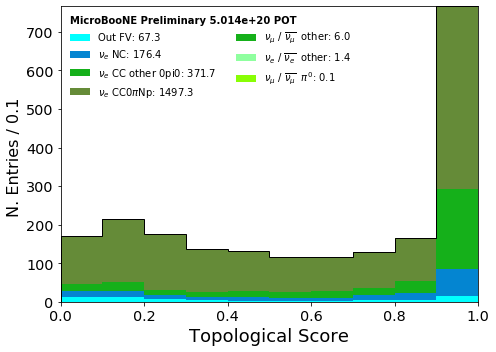

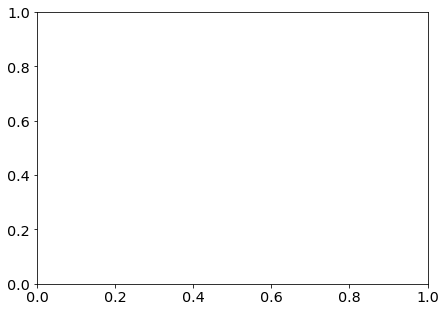

In [205]:

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
    VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score
    
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

n_events here =  736300

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and is_signal==True& topological_score <= 1 & topological_score >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  1497.336042454939
1497.336042454938933587982319295406341552734375000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  1497.336042454939
1497.336042454938933587982319295406341552734375000000000000000000000000000000000
---

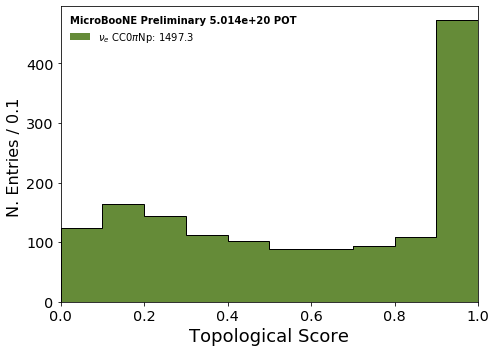

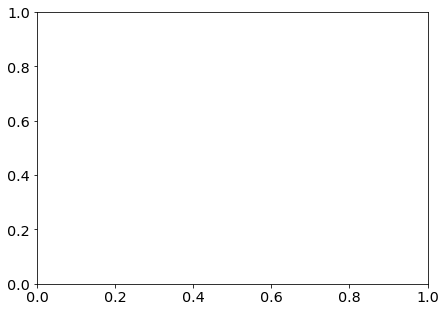

In [213]:
#THE TRUTH THAT WAS SELECTED

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    # NUE
    weights = { #full sample mc = 0.38
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
    VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= SIGNAL_NUMU_SEL_QUERY,
        #query= "is_signal == True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


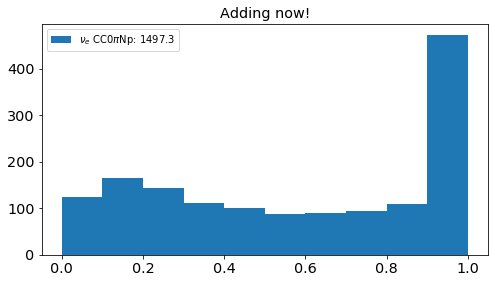

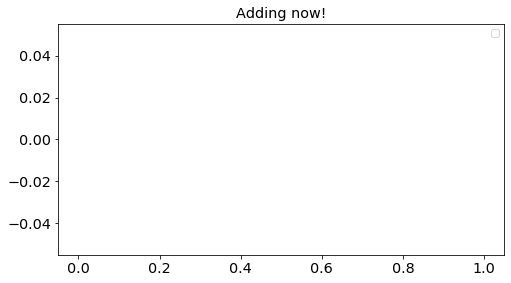

In [214]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [215]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

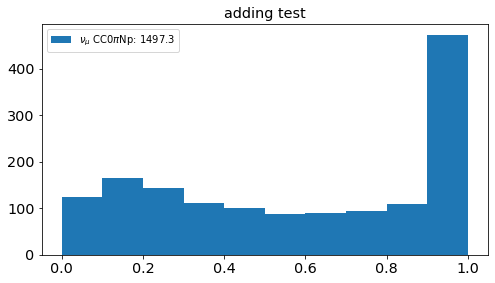

In [216]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [217]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 3  #3

numu_wanted_list = numu_stacked[0]
#numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[124.29376195 164.06389323 144.41507175 111.93143018 101.18863819
  88.1298041   88.79166795  93.20810309 109.42597083 471.88770118]


In [218]:
ending

'Jan19b_TopoCut'

In [219]:
#ending = "Jan19b_NoCut"
#ending = "Jan19b_TriggerCut"
#ending = "Jan19b_VtxXCut"
#ending = "Jan19b_VtxYCut"
#ending = "Jan19b_VtxZCut"
#ending = "Jan19b_MuonCut"
#ending = "Jan19b_ProtonCut"
#ending = "Jan19b_ShowerCut"
#ending = "Jan19b_FracCut"
ending = "Jan19b_TopoCut"
#ending = "Jan19b"

In [220]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

is_selected = True

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"



if isRun3 == False:
    if (is_selected == True):
        if (variable == "Energy"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_'+ending+'.csv')
elif isRun3 == True:
    if (is_selected == True):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_'+ending+'.csv')
    elif (is_selected == False):
        ######full trueE
        if (variable == "Energy"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_allselected_run3_'+ending+'.csv')
        ########angleDiff
        elif (variable == "Angle"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleDiff_usingSelection_allselected_run3_'+ending+'.csv')
        ########leptonMom
        elif (variable == "Lepton"):
            vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
            weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_leptonMom_usingSelection_allselected_run3_'+ending+'.csv')
        

### Stat Errors

In [92]:
#numumcstaterrs

# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Muon_Reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "muon_mom"
    bins = np.arange(0, 2.25, 0.25)


for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[4.696570213744573, 182.02736870246375, 260.6583152523954, 122.90217198167345, 42.24303566416899, 30.18899224559432]


In [93]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_selectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_selectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')


In [94]:
# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Muon_Reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "muon_mom"
    bins = np.arange(0, 2.25, 0.25)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_mc.query(NOT_SIGNAL_NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[3.9327487370549816, 40.1489925999396, 43.77040884824625, 28.686261958616274, 19.93981852724148, 6.702544647425861]


In [95]:
if isRun3 == False:  
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    
elif isRun3 == True:  
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_recoE_usingSelection_recoCut_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_angleDiff_usingSelection_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_updated_errs_full_catsel_nopions_leptonMom_usingSelection_notselectedsig_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')


### Sys Errors

In [136]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5771

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0     1413   954   823  1124  1432   986  1100  1138  1081   471  ...   613   
1     1556    27   241  1395   648  2226   538   806   718  1861  ...   732   
2      955  1373  1255  1832   572   649   322  1172  1358  1190  ...   241   
3     1755  1287  1416  139

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 22.17144585 541.17901611 563.46887207 265.51281738 101.1237793
  65.05273438]


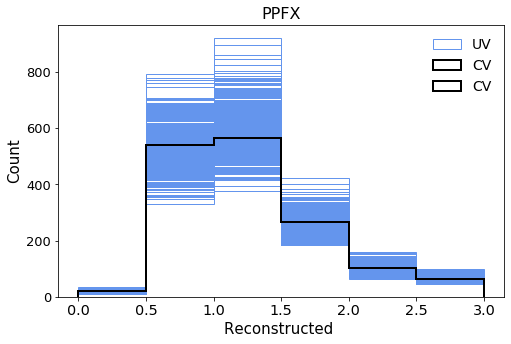

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


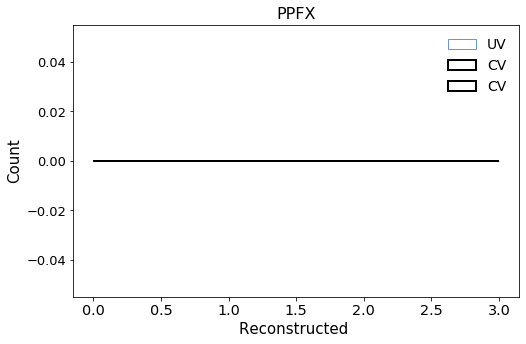

In [137]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [138]:
#will need to edit this if batching

numu_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [139]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [140]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [141]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5771

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   590  \
0      461   623   272  1311   480  1258   839  1383  1149  1348  ...   757   
1      302  1555   193  1608   246   587   759   333   390  1671  ...  2627   
2      892   350   531  1179   933   462  1165   383  1226   435  ...  1047   
3     1277  1059   896  122

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 22.17144585 541.17901611 563.46887207 265.51281738 101.1237793
  65.05273438]


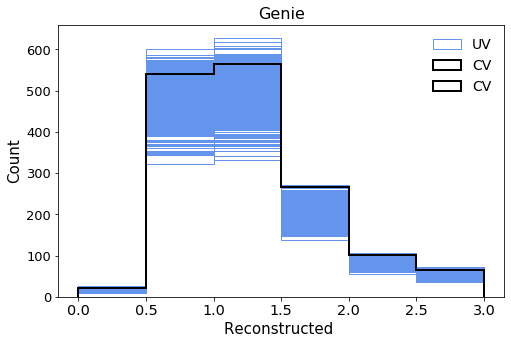

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


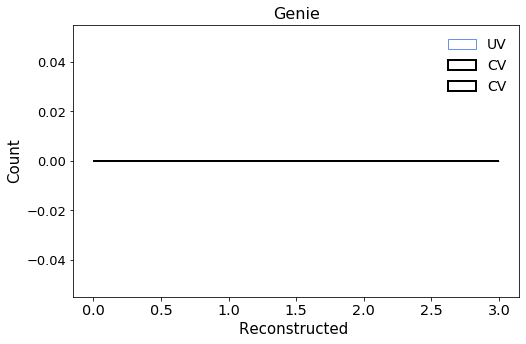

In [142]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [143]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [144]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [145]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [146]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5771

1.0
1
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
       0     1     2     3     4     5     6     7     8     9    ...   990  \
0      923   781  1123  1104  1084   866  1049  1031   949   895  ...   937   
1     1903  1549   577   812  1217  1071   840  1226   881  1534  ...  1421   
2      983   948  1032  1002   974   990   982   986  1021   989  ...   971   
3      960   887  1065  100

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 22.17144585 541.17901611 563.46887207 265.51281738 101.1237793
  65.05273438]


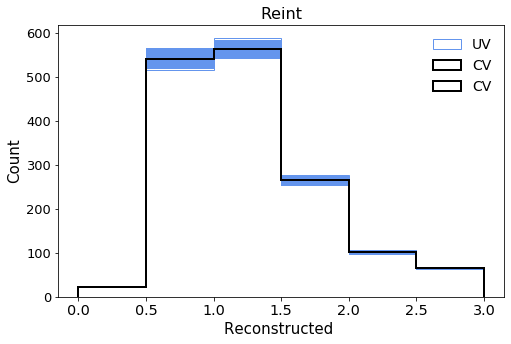

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


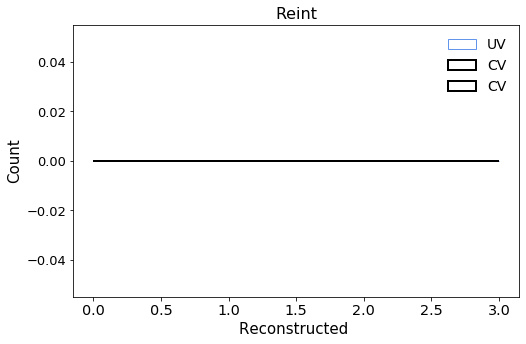

In [147]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [148]:
#will need to edit this if batching

numu_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [149]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [150]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [151]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  5771
1.0
2
{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score > 0.3& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.2528938541850554}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_v

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[ 22.17144585 541.17901611 563.46887207 265.51281738 101.1237793
  65.05273438]


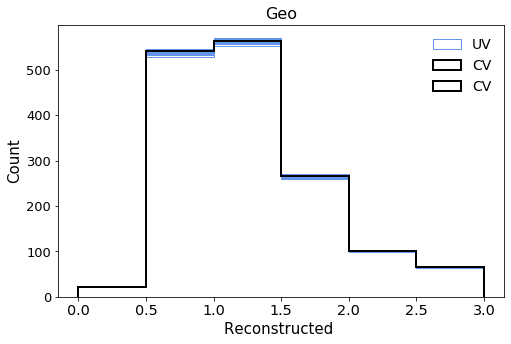

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


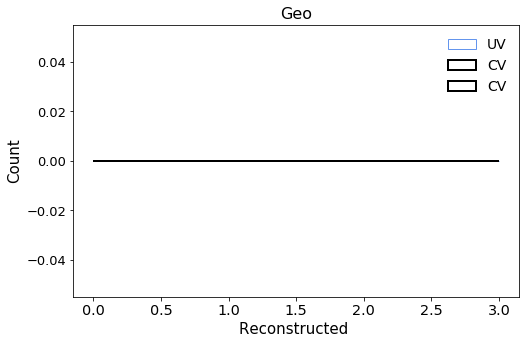

In [152]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [153]:
#will need to edit this if batching

numu_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [154]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [155]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



## NUMU_NUE SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/numi_run1_nue_overlay_fhc'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/numi_run3b_nue_overlay_rhc'+ls.APPEND  

#actually fetch datasets
numu_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_nue]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", "trk_score_v", #"trk_pfp_id",
        "category", "ccnc", "swtrig_pre", "trk_len_v",
        "run","sub","evt", "hits_ratio",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance", "n_tracks_contained",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

#redefine reco e to match nue?

['reco_nu_vtx_x', 'muon_e', '_opfilter_pe_beam', 'run', 'trk_sce_end_y_v', 'flash_pe', 'trk_range_muon_mom_v', 'nslice', 'n_tracks_contained', 'nproton', 'interaction', 'category', 'true_e_visible', 'reco_nu_vtx_z', 'slpdg', 'trk_energy_muon', 'nu_pdg', 'swtrig_pre', 'trk_mcs_muon_mom_v', 'tksh_distance', 'pi0_e', 'elec_e', 'shr_tkfit_dedx_Y', 'slnhits', 'ccnc', 'topological_score', 'slclustfrac', 'CosmicDirAll3D', 'trk_llr_pid_score_v', 'trk_phi', 'trk_sce_end_x_v', 'reco_nu_vtx_y', 'reco_e', 'npion', 'evt', 'n_showers_contained', 'pion_e', 'trk_sce_end_z_v', '_opfilter_pe_veto', 'backtracked_pdg', 'nmuon', 'isVtxInFiducial', 'sub', 'reco_nu_vtx_sce_z', 'trk_score_v', 'trk_len_v', 'shr_energy_tot_cali', 'trk_energy_tot', 'reco_nu_vtx_sce_y', 'contained_fraction', 'proton_e', 'hits_ratio', 'CosmicIP', 'npi0', 'trk_sce_start_x_v', 'trk_theta', 'CosmicIPAll3D', 'reco_nu_vtx_sce_x', 'slnunhits', 'evnunhits']


In [6]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_nue] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_nue = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#approx 3 min run time

trk_llr_pid_v  [[0.8302852 0.41338128 0.7766172 0.08735835] [0.9562783 0.9167327 0.76248056 -0.6253404 0.87921 0.046017326] [] ... [0.9428587] [0.66010433 -0.4793286 -0.07257061 0.19005805] [0.527723]]
trk_score_v  [[0.007776941 0.39978987 0.9841503 0.30731705] [0.005722664 0.0006313614 0.2699833 0.984184 0.8700847 0.61378354] [] ... [0.9923404] [0.084017955 0.9242977 0.89704376 0.80775344] [0.7540588]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
runtime =  36.9927864074707


In [7]:
df_v = [numu_nue]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_nue]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:

numu_nue.query("nu_e > 0 and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)\
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0", inplace=True)
#numu_mc.query("nu_e > 0", inplace=True)

In [10]:
s = time.time()

df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 13 mins
#Run3 = 

runtime =  0.023967266082763672


In [11]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [12]:
df_v = [numu_nue]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [13]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    intrinsic_pot =  2.38181E22
elif isRun3 == True:
    beamon_pot = 5.014E20
    intrinsic_pot =   2.53486e+22   

numu_nue['pot_scale'] = beamon_pot/intrinsic_pot

In [14]:
numu_nue['totweight_data'] = numu_nue['pot_scale']*numu_nue['weightSplineTimesTuneTimesPPFX']
print(numu_nue['totweight_data'])

entry
202       0.015897
352       0.016170
694       0.020314
713       0.021025
802       0.010741
            ...   
123378    0.123788
123899    0.017365
123913    0.023453
123971    0.020740
124039    0.009688
Name: totweight_data, Length: 437, dtype: float64


In [15]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [16]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

runtime =  2.9528729915618896


In [17]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [18]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [19]:
df_v = [numu_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    print(df['trk_mcs_muon_mom_v'])

entry
202       [0.30799952, 0.096000016, 0.6169954, 0.5239968...
352                     [0.37699842, 0.16900016, 1.7250246]
694                                 [0.10800004, 14.999432]
713                    [0.23000029, 0.21200025, 0.14400011]
802       [0.8619925, 0.12600008, 0.71599436, 0.25400028...
                                ...                        
123378                              [0.11200005, 14.992429]
123899    [0.33099928, 14.999432, 0.31899944, 0.36699882...
123913     [0.27499995, 0.121000074, 0.69799453, 14.999432]
123971      [0.28899977, 0.2899998, 0.20200023, 0.22000027]
124039       [0.7889952, 0.12900008, 0.2869998, 0.13000008]
Name: trk_mcs_muon_mom_v, Length: 437, dtype: object


In [20]:
#RECO VARIABLE
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)


entry
202       [289.3577, 292.4198, 305.53726, 313.53775, 216...
352                       [160.71887, 119.69909, 78.077126]
694                                   [461.85492, 440.9387]
713                         [933.6331, 916.4096, 939.61475]
802       [178.6571, 153.41556, 157.90085, 143.6084, 152...
                                ...                        
123378                               [495.97552, 494.53433]
123899    [391.59186, 389.4856, 382.4302, 354.6389, 399....
123913          [1026.4829, 936.93335, 1037.207, 948.63654]
123971            [697.7403, 702.65814, 661.7443, 622.3424]
124039              [851.33813, 858.267, 735.79956, 679.22]
Name: trk_sce_end_z_v, Length: 437, dtype: object
entry
202       0.352838
352       0.345175
694       0.160431
713           0.23
802       0.181204
            ...   
123378    0.143655
123899     0.24195
123913    0.337516
123971    0.297173
124039    0.559672
Name: muon_mom, Length: 437, dtype: object

runetime =  0.15343832969

In [21]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [22]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046
df_v = [numu_nue]

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.009425640106201172


In [23]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [24]:
numu_nue   = numu_nue.query('nu_e > 0.')
#numu_mc.query("nu_e > 0.", inplace=True)

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

Setup complete.

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_nue" : numu_nue
}


if isRun3 == False:
    pot =  2e+20 
    nueratio  = pot/2.38181e+22 
elif isRun3 == True:
    pot =  5.014e20
    nueratio  = pot/2.53486e+22


SPLIT = 1.0
scaling = 1

weights = { 
            "numu_nue"  : nueratio  * SPLIT * scaling   
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_nue': 0.019780185098979827}


In [26]:

dfmc_v = [numu_nue]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1
    

In [27]:
#New categories

for i,df in enumerate(dfmc_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where((df.swtrig_pre==1)&  (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9

    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False), True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [28]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score > 0.3"


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += ' and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += ' and is_signal==False'

In [29]:
test = np.nansum(numu_nue.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

test = np.nansum(numu_nue['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 3.7210027235478575
total signal events = 8.244132898174945


In [27]:
#ENERGY - PRE SAMPLE PLOTS ONLY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.105000
1         0.859165
2         0.105000
3         1.110595
4         0.105000
            ...   
124423    0.105000
124424    0.464745
124425    0.105000
124426    0.452946
124427    0.105000
Name: reco_e, Length: 124428, dtype: float32
entry
0         0.105000
1         0.859165
2         0.105000
3         1.110595
4         0.105000
            ...   
124423    0.105000
124424    0.464745
124425    0.105000
124426    0.452946
124427    0.105000
Name: reco_e, Length: 124428, dtype: float32


In [30]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])
#------
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])

#LEPTON
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] > 2)
tmp[mask] = 1.875
df["muon_mom"] = tmp
print(df["muon_mom"])
#------
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] < 0)
tmp[mask] = 0.125
df["muon_mom"] = tmp
print(df["muon_mom"])


entry
202       0.901171
352       0.958423
694       0.434970
713       0.477320
802       0.876869
            ...   
123378    0.382792
123899    0.105000
123913    0.510654
123971    1.372193
124039    2.059746
Name: reco_e, Length: 437, dtype: float32
entry
202       0.901171
352       0.958423
694       0.434970
713       0.477320
802       0.876869
            ...   
123378    0.382792
123899    0.105000
123913    0.510654
123971    1.372193
124039    2.059746
Name: reco_e, Length: 437, dtype: float32
entry
202       0.256067
352       0.938097
694       0.840493
713      -0.700353
802       0.769361
            ...   
123378    0.464533
123899    0.974063
123913    0.205147
123971   -0.377248
124039    0.980040
Name: cosNu_Angle_Numi_Muon_Reco, Length: 437, dtype: float64
entry
202       0.256067
352       0.938097
694       0.840493
713      -0.700353
802       0.769361
            ...   
123378    0.464533
123899    0.974063
123913    0.205147
123971   -0.377248
124039    0.9

Now plot.

n_events here =  437

1.0
1
{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_nue
--------------------------------------
current sample is:  numu_nue
current_total  3.7210027235478575
3.721002723547857549135642329929396510124206542968750000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  3.7210027235478575
3.72100272354785754913564232992939651012420654296875000000000000

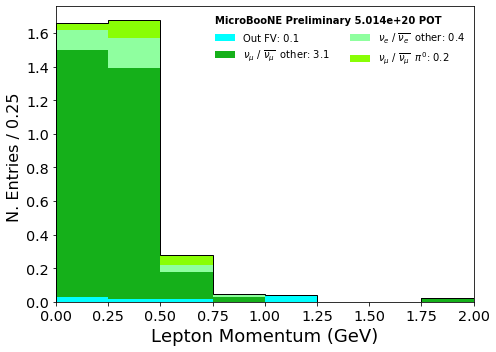

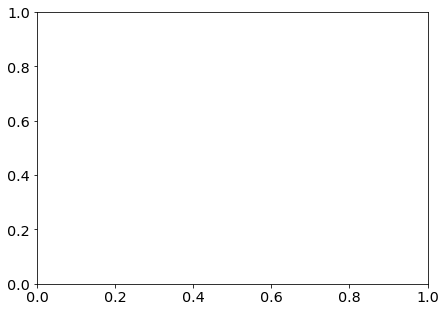

In [43]:
#The numu_nue plot 

import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []
if n_events > 0:
    print(n_events/batch_size)
    print(int(n_events/batch_size))

    for i in range(int(n_events/batch_size)+1):
        start = i*batch_size
        if (start + batch_size) < n_events:
            end = start + batch_size
        else:
            end = n_events
        sample_set = numu_nue.iloc[start:end]

        samples = {
            "numu_nue": sample_set 
        }


        scaling = 1
        if isRun3 == False:
            pot =  2e+20 
            nueratio  = pot/2.38181e+22 
        elif isRun3 == True:
            pot =  5.014e20
            nueratio  = pot/2.53486e+22 

        # NUE
        weights = { #full sample mc = 0.38
                    "numu_nue"  : nueratio  * SPLIT * scaling
        }


        my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
        print(weights)


        #Now check on a variable
        #Remember to change the plotter keys between truth and mc

        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
        #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
        #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
        #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
        #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
        #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
        #VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score

        
        #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
        #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
        VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

        var, weight, label = my_plotter.plot_variable(
            VARIABLE,
            query= NUMU_SEL_QUERY,
            #query= "",
            currentsample = "numu_nue",
            kind="event_category",
            draw_sys  = True, 
            draw_geoSys = True, 
            draw_data = True,
            ratio=False,
            genieweight = "weightSplineTimesTuneTimesPPFX",  
            stacksort=3,
            title=XTIT,
            bins=BINS,
            range=RANGE
        )[0:3]

        varss.append(var)
        weightss.append(weight)
        labss.append(label)

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3245: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
No handles with labels found to put in legend.


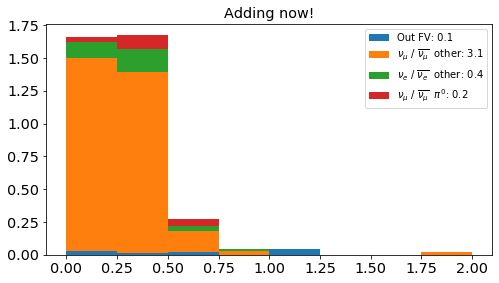

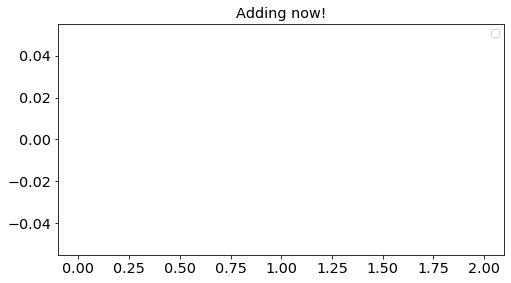

In [44]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-20, 280])    #Vtx X
    #numu_ax1.set_xlim([-140, 140])    #Vtx Y
    #numu_ax1.set_xlim([-10, 1100])    #Vtx Z
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [45]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

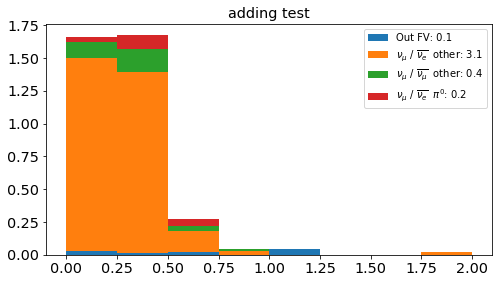

In [46]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_xlim([-20, 280])
#numu_ax1.set_xlim([-140, 140])
#numu_ax1.set_xlim([-10, 1100])
#numu_ax1.set_ylim([0, 1000])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 1000])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [47]:
#ending = "Jan19b_NoCut"
#ending = "Jan19b_TriggerCut"
#ending = "Jan19b_VtxXCut"
#ending = "Jan19b_VtxYCut"
#ending = "Jan19b_VtxZCut"
#ending = "Jan19b_MuonCut"
#ending = "Jan19b_ProtonCut"
#ending = "Jan19b_ShowerCut"
#ending = "Jan19b_FracCut"
#ending = "Jan19b_TopoCut"
ending = "Jan19b"

In [48]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"

if isRun3 == False:
    ######full true
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full true
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_nue_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_nue_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')

### Stat Errors

In [53]:
#numunuestat

# sumw2 of the full event rate 
weight_stat_errs = []

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Muon_Reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "muon_mom"
    bins = np.arange(0, 2.25, 0.25)


for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_nue.query(NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[0.06853982382479441, 0.046000830086279705, 0.004886589387472421, 0.0011290944667863387, 0.0008713230834791462, 0, 0, 0.0004748529765145906]


In [54]:
if isRun3 == False:    
    if (variable == "Energy"):
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"): 
        #corrected double __
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

elif isRun3 == True:  
    if (variable == "Energy"):
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"): 
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')


### Sys Errors

In [105]:
#############################
##### weightsPPFX ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  437

1.0
1
{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5    6     7     8     9    ...   590  \
0     828  1194  1120   744   476  1148  403   441   720   868  ...  1558   
1    1542    12    42   191     0   373  306   420  1163  6420  ...   275   
2     771   663   926   611   947   778  457  1344  1237   899  ...   603   
3     746   856    96  1160 

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.65879428 1.67513955 0.27677941 0.04675937 0.04173899 0.
 0.         0.02179122]


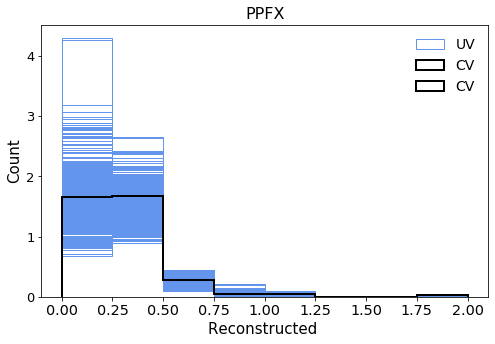

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


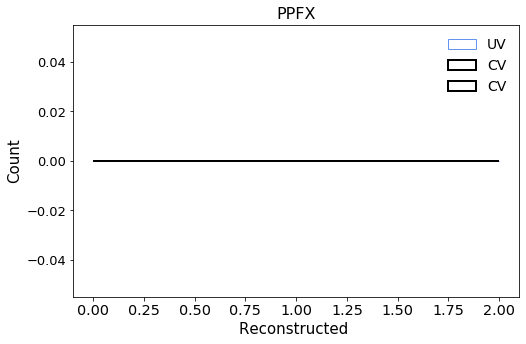

In [106]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)


    plt.show()

In [107]:
#will need to edit this if batching

numu_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_ppfx_detvar_dict.to_csv('numu_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [108]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_nue_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [109]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_nue_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [110]:
#############################
##### weightsgenie ###########  NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22 
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  437

1.0
1
{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   590  \
0    1832   622  2333   382   350  1021   629   406   727   302  ...   796   
1     982   394   560  1321  1035   519  1293   446  1366   480  ...  1156   
2    1327  2107  1796   641   360   971   544  1070  1185   395  ...   540   
3    1031  1939  2161   

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.65879428 1.67513955 0.27677941 0.04675937 0.04173899 0.
 0.         0.02179122]


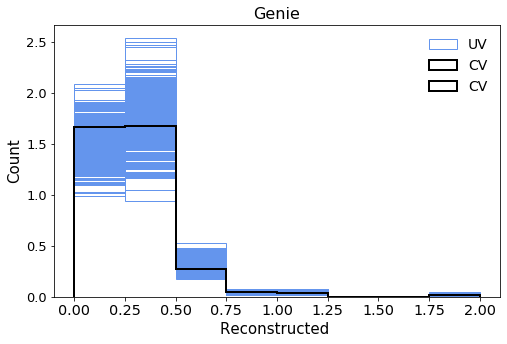

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


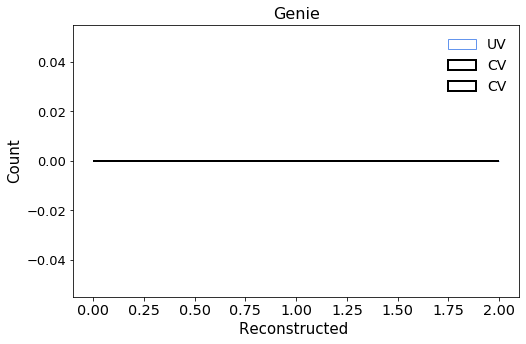

In [111]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [112]:
#will need to edit this if batching

numu_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_genie_detvar_dict.to_csv('numu_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [113]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_genie.append(sum(masterlist[a]))

final_ncvs_numu_nue_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [114]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_nue_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_nue_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_nue_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [115]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"


    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  437

1.0
1
{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
      0     1     2     3     4     5     6     7     8     9    ...   990  \
0     834   587  1286  1029   736   919   925   880  1268   875  ...   800   
1     991   974  1016  1000   988   994   990   993  1010   995  ...   985   
2     986   957  1028  1001   979   991   984   989  1017   991  ...   975   
3     985   915  1143   

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.65879428 1.67513955 0.27677941 0.04675937 0.04173899 0.
 0.         0.02179122]


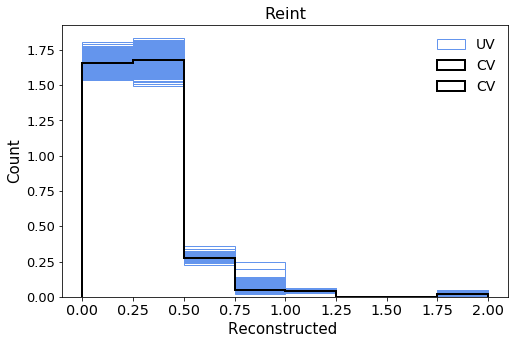

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


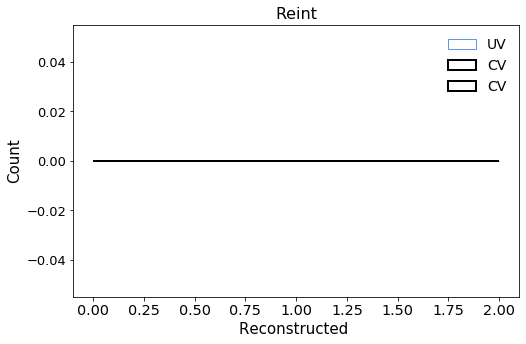

In [116]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [117]:
#will need to edit this if batching

numu_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_nue_reint_detvar_dict.to_csv('numu_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
  

In [118]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_reint.append(sum(masterlist[a]))

final_ncvs_numu_nue_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [119]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_nue_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_nue_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_nue_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [120]:
#############################
##### weightsNuMIGeo ###########   NUE
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_nue.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_nue.iloc[start:end]

    samples = {
        "numu_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22
    
    weights = {
               "numu_nue"  : nueratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  437
1.0
2
{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_nue': 0.019780185098979827}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.65879428 1.67513955 0.27677941 0.04675937 0.04173899 0.
 0.         0.02179122]


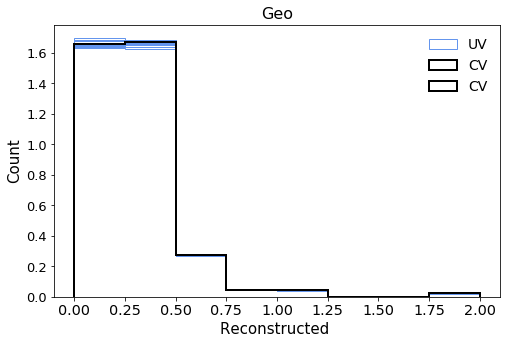

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


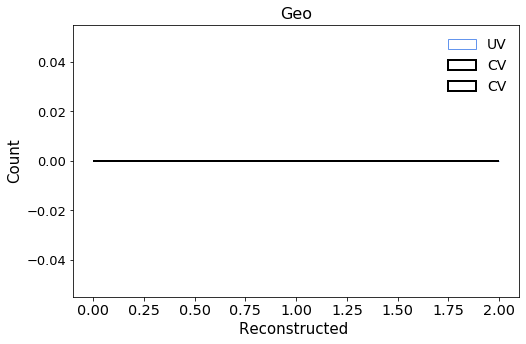

In [121]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [122]:
#will need to edit this if batching

numu_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    if (variable == "Angle"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    if (variable == "Lepton"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    if (variable == "Angle"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    if (variable == "Lepton"):
        numu_nue_geo_detvar_dict.to_csv('numu_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [123]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_nue_geo.append(sum(masterlist[a]))

final_ncvs_numu_nue_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_nue_geo)):
    final_ns_numu_nue_geo[x] = np.concatenate((final_ns_numu_nue_geo[x][0], final_ns_numu_nue_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [124]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    if (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    if (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    if (variable == "Angle"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    if (variable == "Lepton"):
        np.savetxt("numu_nue_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_nue_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_nue_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_nue_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_nue_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



## NUMU_DIRT SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
if isRun3 == False:
    DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND
elif isRun3 == True:
    DRT  = '/neutrinoselection_filt_run3b_dirt_overlay'  +ls.APPEND

#actually fetch datasets
numu_dirt  = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_dirt]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", "trk_pfp_id",
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt", "contained_fraction",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "reco_e", "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "proton_e", "elec_e",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['nu_pdg', 'flash_pe', 'trk_sce_start_x_v', 'evt', 'pi0_e', 'backtracked_pdg', 'swtrig_pre', 'topological_score', 'shr_energy_tot_cali', 'trk_mcs_muon_mom_v', 'CosmicDirAll3D', 'npion', 'trk_sce_end_y_v', 'slnunhits', 'category', 'trk_range_muon_mom_v', 'shr_tkfit_dedx_Y', 'elec_e', 'trk_energy_muon', 'trk_energy_tot', 'reco_nu_vtx_sce_z', 'CosmicIPAll3D', 'reco_nu_vtx_y', 'n_showers_contained', 'trk_theta', 'slpdg', 'npi0', 'trk_llr_pid_score_v', 'interaction', 'reco_nu_vtx_z', 'slclustfrac', '_opfilter_pe_beam', 'slnhits', 'tksh_distance', 'sub', 'CosmicIP', 'run', 'contained_fraction', 'muon_e', 'reco_nu_vtx_sce_y', 'reco_e', 'trk_phi', 'pion_e', 'nmuon', 'reco_nu_vtx_x', '_opfilter_pe_veto', 'proton_e', 'true_e_visible', 'pi0truth_elec_etot', 'nproton', 'evnunhits', 'isVtxInFiducial', 'reco_nu_vtx_sce_x', 'trk_sce_end_x_v', 'nslice', 'trk_sce_end_z_v', 'ccnc']


In [6]:
import time
s = time.time()

import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS + PPFX

# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 



for ii, CV in enumerate(uproot_v):
    print("1")
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print()
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        print("4")
        numu_dirt =  CVDF

s2 = time.time()

print("runtime = ", s2-s)
#Approx 5 mins

1

2
trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
3
4
runtime =  115.09509444236755


In [7]:
df_v = [numu_dirt]

#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
numu_dirt.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)


In [10]:
s = time.time()

df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Run1 = 
#Run3 = 

runtime =  0.021901369094848633


In [11]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    dirt_pot =  1.67392e+21
    scalingDRT = 0.65
elif isRun3 == True:
    beamon_pot = 5.014E20
    dirt_pot =  1.03226e+21
    scalingDRT = 0.45    

numu_dirt['pot_scale'] = (beamon_pot/dirt_pot)*scalingDRT

In [12]:
numu_dirt['totweight_data'] = numu_dirt['pot_scale']*numu_dirt['weightSplineTimesTuneTimesPPFX']
print(numu_dirt['totweight_data'])

entry
3527      0.080040
4255      0.097515
4633      0.051532
6008      0.065349
6597      0.078450
            ...   
564832    0.047020
565244    0.078976
565770    0.060690
565983    0.101247
566221    0.050332
Name: totweight_data, Length: 291, dtype: float64


In [13]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [14]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [15]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5963/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  7.56011962890625


In [16]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [17]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [18]:
#RECO VARIABLE
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
3527                  [216.6536, 179.14412]
4255                   [878.6665, 946.2457]
4633        [307.1298, 306.15985, 307.9991]
6008                  [472.0022, 456.68082]
6597      [899.77264, 906.25354, 811.46246]
                        ...                
564832               [389.11575, 289.59225]
565244                [151.35966, 88.21207]
565770     [866.66345, 871.2874, 862.18304]
565983     [678.0295, 509.40195, 475.88098]
566221                  [835.3216, 933.008]
Name: trk_sce_end_z_v, Length: 291, dtype: object
entry
3527      0.317174
4255      0.392615
4633      0.399214
6008      0.281314
6597      0.490133
            ...   
564832    0.354059
565244     0.30428
565770    0.165098
565983    0.692385
566221    0.395383
Name: muon_mom, Length: 291, dtype: object

runetime =  0.11898469924926758


In [19]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [20]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046
df_v = [numu_dirt]

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.007948160171508789


In [21]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [22]:
numu_dirt   = numu_dirt.query('nu_e > 0.')

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)

In [23]:

df_v = [numu_dirt]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1

In [24]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.swtrig_pre==1)&(df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

Set up complete.

In [25]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_dirt"  : numu_dirt
}

scaling = 1
SPLIT = 1.0

if isRun3 == False:
    pot       =  2e+20
    dirtratio = pot/1.67392+21
    scalingDRT = 0.65 #0.35
elif isRun3 == True:
    pot       =  5.014e+20
    dirtratio = pot/1.03226e+21
    scalingDRT = 0.45   

weights = {  "numu_dirt": dirtratio* SPLIT * scalingDRT,  
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'numu_dirt': 7.766201491110688e+19}


In [26]:
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 \
and contained_fraction> 0.95 and topological_score >0.3"


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += ' and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += ' and is_signal==False'

In [27]:
test = np.nansum(numu_dirt.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

test = np.nansum(numu_dirt['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 2.8541512393005783
total signal events = 21.243067530436495


In [25]:
#ENERGY - FOR SET UP PLOTS
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.105
1         0.105
2         0.105
3         0.105
4         0.105
          ...  
569501    0.105
569502    0.105
569503    0.105
569504    0.105
569505    0.105
Name: reco_e, Length: 569506, dtype: float32
entry
0         0.105
1         0.105
2         0.105
3         0.105
4         0.105
          ...  
569501    0.105
569502    0.105
569503    0.105
569504    0.105
569505    0.105
Name: reco_e, Length: 569506, dtype: float32


In [28]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])
#------
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])

#LEPTON
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] > 2)
tmp[mask] = 1.875
df["muon_mom"] = tmp
print(df["muon_mom"])
#------
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] < 0)
tmp[mask] = 0.125
df["muon_mom"] = tmp
print(df["muon_mom"])

entry
3527      0.808543
4255      1.028632
4633      1.140013
6008      0.785061
6597      1.489785
            ...   
564832    0.996420
565244    0.799480
565770    0.372489
565983    1.617240
566221    0.999725
Name: reco_e, Length: 291, dtype: float32
entry
3527      0.808543
4255      1.028632
4633      1.140013
6008      0.785061
6597      1.489785
            ...   
564832    0.996420
565244    0.799480
565770    0.372489
565983    1.617240
566221    0.999725
Name: reco_e, Length: 291, dtype: float32
entry
3527      0.341467
4255     -0.800791
4633      0.251047
6008     -0.144957
6597      0.720795
            ...   
564832    0.806788
565244    0.643271
565770    0.828787
565983    0.989585
566221   -0.866412
Name: cosNu_Angle_Numi_Muon_Reco, Length: 291, dtype: float64
entry
3527      0.341467
4255     -0.800791
4633      0.251047
6008     -0.144957
6597      0.720795
            ...   
564832    0.806788
565244    0.643271
565770    0.828787
565983    0.989585
566221   -0.8

Plots

n_events here =  291

1.0
1
{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_dirt
--------------------------------------
current sample is:  numu_dirt
current_total  2.8541512393005783
2.854151239300578346558268094668164849281311035156250000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  2.8541512393005783
2.85415123930057834655826809466816484928131103515625000000000000

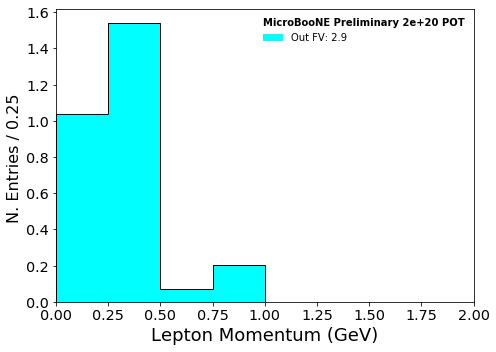

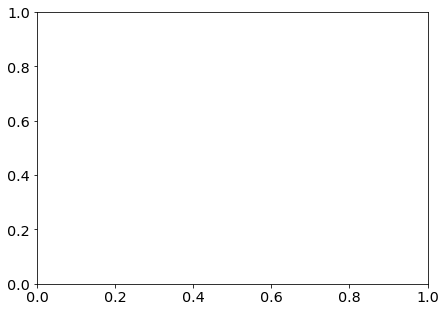

In [43]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score

    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_dirt",
        kind="event_category",
        #kind="psrticle_pdg",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


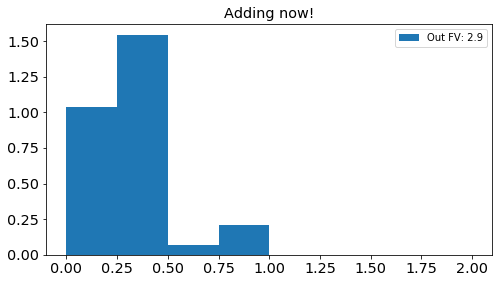

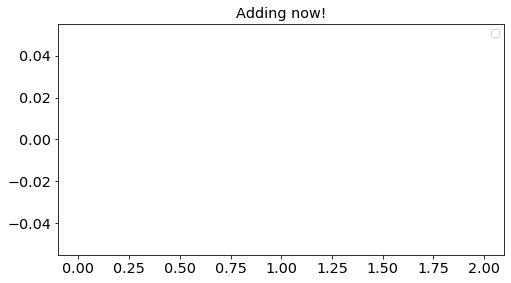

In [44]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff
    
    #print(varss)

    numu_stacked = numu_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [45]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

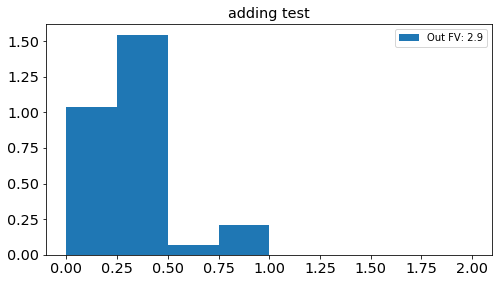

In [46]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 30])

##AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 15])

numu_stacked = numu_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [47]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [48]:
#ending = "Jan19b_NoCut"
#ending = "Jan19b_TriggerCut"
#ending = "Jan19b_VtxXCut"
#ending = "Jan19b_VtxYCut"
#ending = "Jan19b_VtxZCut"
#ending = "Jan19b_MuonCut"
#ending = "Jan19b_ProtonCut"
#ending = "Jan19b_ShowerCut"
#ending = "Jan19b_FracCut"
#ending = "Jan19b_TopoCut"
ending = "Jan19b"

In [49]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"

if isRun3 == False:
    ######full true
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full true
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_dirt_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_dirt_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Err

In [54]:
#numudirtstat 

# sumw2 of the full event rate 
weight_stat_errs = []

#variable = "Energy"
#variable = "Angle"
variable = "Lepton"


if (variable == "Energy"):
    xvar = "reco_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Muon_Reco"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "muon_mom"
    bins = np.arange(0, 2.25, 0.25)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_dirt.query(NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[0.08017673163265444, 0.12519099428406308, 0.004945175944221507, 0.01722995621756271, 0, 0, 0, 0]


In [55]:

if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_stat_errs_updated_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    

### Sys Errs

In [96]:
############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  291
n_events/2 here =  145.0

1.0
1
{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0    601  1622  1172  1077   493   170   675   807  1045   243  ...  1000   
1   1072   343   754   564   286   151   152   540   464   158  ...  1000   
2    169     1   740  1056     4   672   281   243   542   905  ...  1000   
3   1

{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------



[1.03616905 1.54186964 0.07032204 0.20579052 0.         0.
 0.         0.        ]


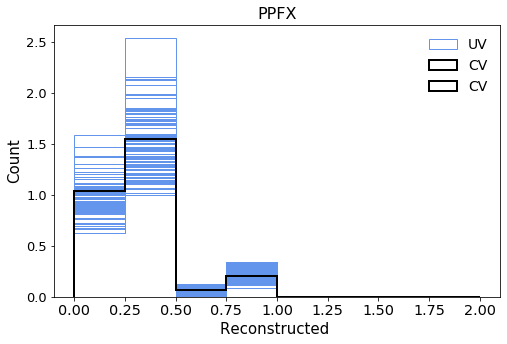

[0. 0. 0. 0. 0. 0. 0. 0.]


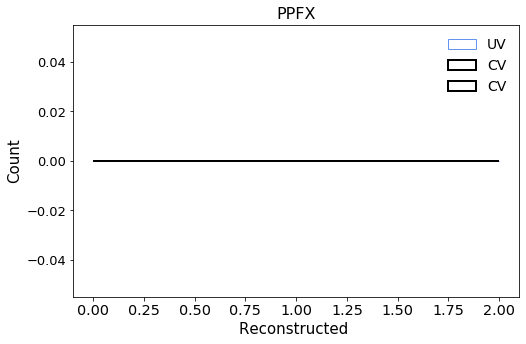

In [97]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [98]:
#will need to edit this if batching

numu_dirt_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_dirt_ppfx_detvar_dict.to_csv('numu_dirt_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')
    

In [99]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_ppfx.append(sum(masterlist[a]))

final_ncvs_numu_dirt_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [100]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')


        ###########################################

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_dirt_syserss_df_ppfx_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_dirt_syserss_df_ppfx_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_dirt_syserss_df_ppfx_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [101]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse = 500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  291
n_events/2 here =  145.0

1.0
1
{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
1    999   421   573  1385  1037   542  1338   484  1430   494  ...  1000   
2    942   607   848  1179  1115   988  1251  1026   391   855  ...  1000   
3   1

Returning
--------------------------

{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------



[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.03616905 1.54186964 0.07032204 0.20579052 0.         0.
 0.         0.        ]


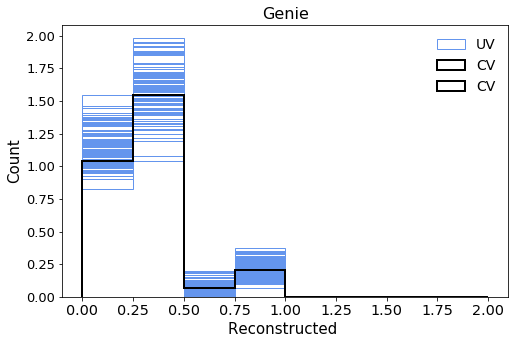

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


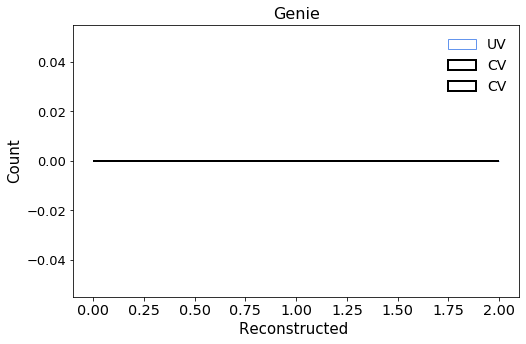

In [102]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Genie', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [103]:
#will need to edit this if batching

numu_dirt_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_dirt_genie_detvar_dict.to_csv('numu_dirt_syserss_df_genie_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [104]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_genie.append(sum(masterlist[a]))

final_ncvs_numu_dirt_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


     0     1     2     3     4     5     6     7     8     9    ...   590  \
0   2973   392   991  1021   638  2093  1545   874  1298  1167  ...  1000   
1    999   421   573  1385  1037   542  1338   484  1430   494  ...  1000   
2    942   607   848  1179  1115   988  1251  1026   391   855  ...  1000   
3   1273  1133  1086  1222  1153  1273  1175  1149  1224  1260  ...  1000   
4    766   507   789  1161   648   384  1056   257  1245   452  ...  1000   
5   1365  1075   871  1300  1109  1416  1168  1202  1322  1321  ...  1000   
6   1220   403   406  1671   898   714  1361   535  1783   582  ...  1000   
7   1646   408  1161   646   475  1542   986   786   748   922  ...  1000   
8   1063   992  1023  1024  1003  1050  1009   968  1020  1061  ...  1000   
9   1320  1068   893  1263  1097  1365  1148  1179  1283  1281  ...  1000   
10     0     0     0     0     0     0     0     0     0     0  ...  1000   
11     0   737   565  1528  1383   366  1001  1515  1152   803  ...  1000   

In [105]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_dirt_syserss_df_genie_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_dirt_syserss_df_genie_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_dirt_syserss_df_genie_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')



In [106]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
print("weightsReint")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
        
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  291
n_events/2 here =  145.0
weightsReint
1.0
1
{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
     0     1     2     3     4     5     6     7     8     9    ...   990  \
0   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
1   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1000   
2   1000  1000  1000  1000  1000  1000  1000  1000  1000  1000  ...  1

Returning
--------------------------

{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
Empty DataFrame
Columns: []
Index: []
Returning
--------------------------



[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.03616905 1.54186964 0.07032204 0.20579052 0.         0.
 0.         0.        ]


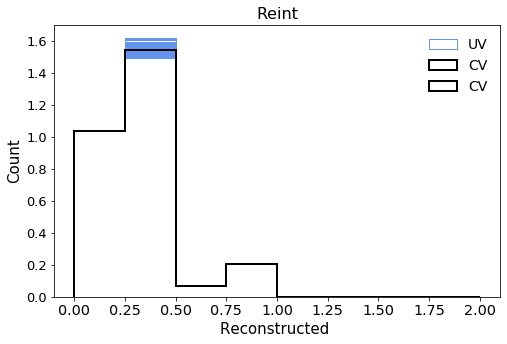

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


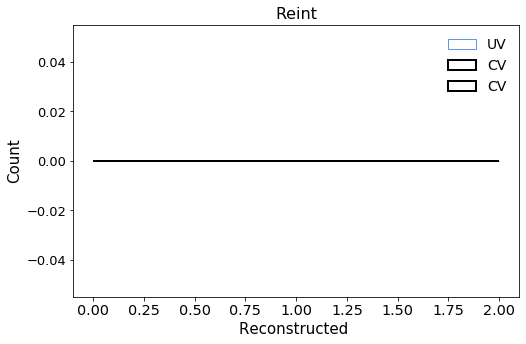

In [107]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [108]:
#will need to edit this if batching

numu_dirt_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])


if isRun3 == False:
    if (variable  == "Energy"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable  == "Angle"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable  == "Lepton"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable  == "Energy"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable  == "Angle"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable  == "Lepton"):
        numu_dirt_reint_detvar_dict.to_csv('numu_dirt_syserss_df_reint_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [109]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_reint.append(sum(masterlist[a]))

final_ncvs_numu_dirt_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [110]:
if isRun3 == False:
    if (variable  == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable  == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable  == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable  == "Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable  == "Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable  == "Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_dirt_syserss_df_reint_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_dirt_syserss_df_reint_vars_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_dirt_syserss_df_reint_splines_full_500_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


In [111]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/2))
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 
        dirtratio = pot/1.67392e+21
        scalingDRT = 0.65
    elif isRun3 == True:
        pot =  5.014e+20
        dirtratio = pot/1.03226e+21
        scalingDRT = 0.45
    
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT, #set0  
    }



    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,   
        query= NUMU_SEL_QUERY,
        currentsample = "numu_dirt",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  291
n_events/2 here =  145.0
1.0
2
{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0 and contained_fraction> 0.95 and topological_score >0.3& muon_mom <= 2 & muon_mom >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_dirt': 0.07766201491110687}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and rec

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[1.03616905 1.54186964 0.07032204 0.20579052 0.         0.
 0.         0.        ]


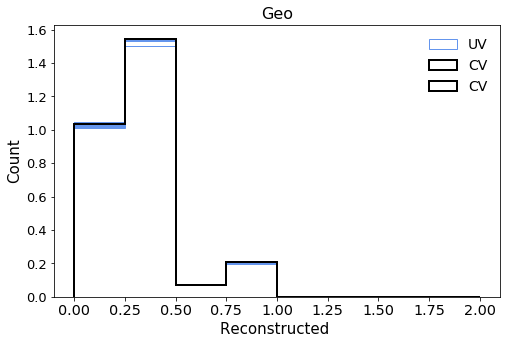

[0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0. 0. 0. 0. 0. 0. 0. 0.]


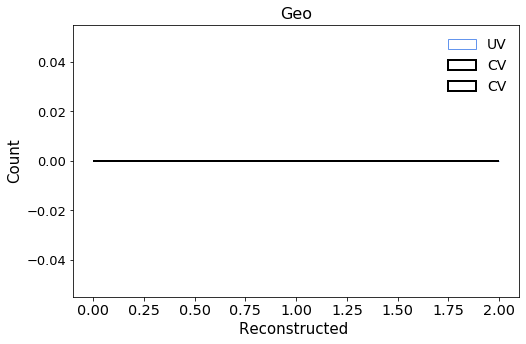

In [112]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    #variable = "Energy"
    #variable = "Angle"
    variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)

    plt.show()

In [113]:
#will need to edit this if batching

numu_dirt_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable =="Energy"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable =="Angle"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_'+ending+'.csv')
    elif (variable =="Lepton"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_'+ending+'.csv')
elif isRun3 == True:
    if (variable =="Energy"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable =="Angle"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_angleDiff_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable =="Lepton"):
        numu_dirt_geo_detvar_dict.to_csv('numu_dirt_syserss_df_geo_detvar_dict_full_500_catsel_nopions_leptonMom_usingSelection_recoCut_run3_'+ending+'.csv')

In [114]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_dirt_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_dirt_geo.append(sum(masterlist[a]))

final_ncvs_numu_dirt_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_numu_dirt_geo)):
    final_ns_numu_dirt_geo[x] = np.concatenate((final_ns_numu_dirt_geo[x][0], final_ns_numu_dirt_geo[x][1]))
    
    
#print(final_ns_numu_dirt_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [115]:
if isRun3 == False:
    if (variable =="Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable =="Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    elif (variable =="Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable =="Energy"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable =="Angle"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    elif (variable =="Lepton"):
        np.savetxt("numu_dirt_syserss_final_ns_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ns_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_dirt_syserss_final_ncvs_geo_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   final_ncvs_numu_dirt_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('numu_dirt_syserss_df_geo_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_dirt_syserss_df_geo_vars_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_dirt_syserss_df_geo_splines_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


## NUMU_EXT

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#EXT  = '/pre_samp/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
#full sample
if isRun3 == False:
    EXT  = '/neutrinoselection_filt_run1_beamoff'         +ls.APPEND
elif isRun3 == True:
    EXT  = '/neutrinoselection_filt_run3b_beamoff'         +ls.APPEND

#actually fetch datasets
numu_ext  = uproot.open(ls.ntuple_path+EXT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_ext]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre", 
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction", 
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['category', 'npion', 'flash_pe', 'trk_sce_end_z_v', 'slclustfrac', 'reco_nu_vtx_sce_z', 'trk_mcs_muon_mom_v', 'nu_pdg', 'trk_theta', 'pion_e', 'ccnc', 'contained_fraction', '_opfilter_pe_veto', 'trk_phi', 'evt', 'reco_nu_vtx_sce_y', 'reco_nu_vtx_x', 'reco_nu_vtx_y', 'npi0', '_opfilter_pe_beam', 'true_e_visible', 'trk_sce_start_x_v', 'trk_range_muon_mom_v', 'nslice', 'interaction', 'sub', 'slpdg', 'reco_nu_vtx_z', 'shr_energy_tot_cali', 'proton_e', 'evnunhits', 'run', 'muon_e', 'isVtxInFiducial', 'trk_energy_muon', 'elec_e', 'n_showers_contained', 'slnunhits', 'trk_sce_end_y_v', 'swtrig_pre', 'reco_nu_vtx_sce_x', 'trk_energy_tot', 'CosmicDirAll3D', 'nproton', 'trk_sce_end_x_v', 'CosmicIP', 'pi0truth_elec_etot', 'nmuon', 'slnhits', 'backtracked_pdg', 'shr_tkfit_dedx_Y', 'reco_e', 'trk_llr_pid_score_v', 'tksh_distance', 'pi0_e', 'CosmicIPAll3D', 'topological_score']


In [6]:
import time
s = time.time()

import pandas as pandas

ext_var  = numu_variables + numu_varMC  ##added second part

# This needs modifications (add variables from above)
uproot_v = [numu_ext] 
var_v    = [ext_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_ext = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [0.97052354 0.46686205] [] [0.9231277]]
trk_score_v  [[] [] [] ... [1.0 0.010001138] [] [0.9994478]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
466.0181610584259


In [7]:
if isRun3 == False:
    # The EXT sample (off beam) is scaled using the triggers (there's no POT in the external sample!)
    extratio  = 5268051/9199232.74
    # We scale down the EXT to account for neutrino occupancy
    scalingEXT = 0.98
elif isRun3 == True:
    extratio  = 10363728.0/32878305.25
    scalingEXT = 0.98

numu_ext['pot_scale'] = extratio * scalingEXT

In [8]:
numu_ext['totweight_data'] = numu_ext['pot_scale']

In [9]:
df_v = [numu_ext]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_ext]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    #df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_ext["extdata"] = np.ones_like(numu_ext["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_14440/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  26.337339162826538


In [12]:
#numu_ext["is_signal"]   = numu_ext["category"] == 2

In [13]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [14]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [15]:
numu_ext.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained == 0", inplace=True)


In [16]:
#RECO VARIABLE
df_v = [numu_ext]
    
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
3254                    [623.5206, 605.3592]
3822          [605.6201, 613.9986, 401.3665]
6047         [827.39435, 808.5187, 821.0348]
9098        [291.9362, 327.65396, 245.72343]
18640                   [573.7536, 527.9679]
                         ...                
3201974                  [552.0224, 525.887]
3202579      [586.32043, 561.3431, 556.3789]
3206252    [287.89584, 255.76543, 260.67233]
3209792               [743.06006, 742.64233]
3210076      [969.3807, 739.5761, 884.46936]
Name: trk_sce_end_z_v, Length: 1583, dtype: object
entry
3254        0.25293
3822       0.135157
6047        0.18796
9098       0.468977
18640      0.470768
             ...   
3201974    0.464931
3202579    0.271081
3206252    0.335463
3209792    0.237128
3210076    0.396571
Name: muon_mom, Length: 1583, dtype: object

runetime =  0.7204024791717529


In [17]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [18]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046
df_v = [numu_ext]

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.02173590660095215


In [19]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [20]:
df_v = [numu_ext]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1


 Setup complete.

In [21]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_ext"  : numu_ext
}

SPLIT = 1.0
scaling = 1
scalingEXT = 0.98

if isRun3 == False:
    pot =  2e+20
    extratio  = 5268051/9199232.74 
elif isRun3 == True:
    pot =  5.014e+20
    extratio  = 10363728.0/32878305.25


weights = {   "ext" : extratio * SPLIT * scalingEXT, 
}

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{'ext': 0.3089104916683624}


In [22]:
"""
#No true query as data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  \
and contained_fraction> 0.95 and topological_score > 0.3"

#no truth as is data

SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [23]:
test = np.nansum(numu_ext.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))
test = np.nansum(numu_ext.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 0.0
total signal events = 52.20587309195325


In [18]:
#ENERGY - FOR PRE CUTS
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0          0.105
1          0.105
2          0.105
3          0.105
4          0.105
           ...  
3211092    0.105
3211093    0.105
3211094    0.105
3211095    0.105
3211096    0.105
Name: reco_e, Length: 3211097, dtype: float32
entry
0          0.105
1          0.105
2          0.105
3          0.105
4          0.105
           ...  
3211092    0.105
3211093    0.105
3211094    0.105
3211095    0.105
3211096    0.105
Name: reco_e, Length: 3211097, dtype: float32


In [24]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])
#------
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])

#LEPTON
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] > 2)
tmp[mask] = 1.875
df["muon_mom"] = tmp
print(df["muon_mom"])
#------
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] < 0)
tmp[mask] = 0.125
df["muon_mom"] = tmp
print(df["muon_mom"])

entry
3254       0.728414
3822       0.105000
6047       0.743812
9098       1.096470
18640      1.133256
             ...   
3201974    1.234044
3202579    0.820356
3206252    0.946970
3209792    0.294362
3210076    1.152337
Name: reco_e, Length: 1583, dtype: float32
entry
3254       0.728414
3822       0.105000
6047       0.743812
9098       1.096470
18640      1.133256
             ...   
3201974    1.234044
3202579    0.820356
3206252    0.946970
3209792    0.294362
3210076    1.152337
Name: reco_e, Length: 1583, dtype: float32
entry
3254       0.424988
3822       0.974589
6047       0.504157
9098       0.215053
18640      0.041491
             ...   
3201974    0.089337
3202579    0.758749
3206252    0.576982
3209792   -0.086254
3210076   -0.810653
Name: cosNu_Angle_Numi_Muon_Reco, Length: 1583, dtype: float64
entry
3254       0.424988
3822       0.974589
6047       0.504157
9098       0.215053
18640      0.041491
             ...   
3201974    0.089337
3202579    0.758749
3206252

No handles with labels found to put in legend.


n_events here =  1583

1.0
1
{'ext': 0.3089104916683624}
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0 and n_showers_contained==0  and contained_fraction> 0.95 and topological_score > 0.3& reco_e <= 3 & reco_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_ext
--------------------------------------
current_plotted_variable  [0.99154323 0.8543222  0.4473142  0.99108255 0.57240343 1.3090426
 0.8278827  1.3921014  1.2407814  2.006077   0.79405963 0.71257615
 0.72928995 1.0474586  1.169793   1.320112   0.9625468  0.9374105
 1.3012116  0.7574513  1.3154514  1.003028   1.1126043  0.6542366
 1.1513277  0.84870195 1.1501015  0.9

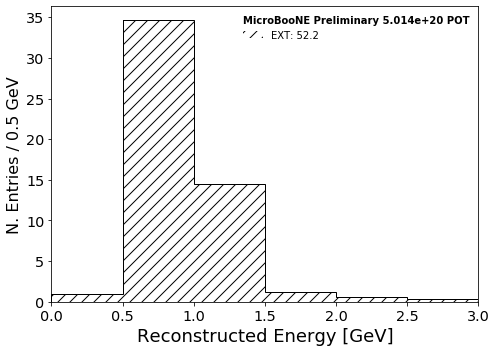

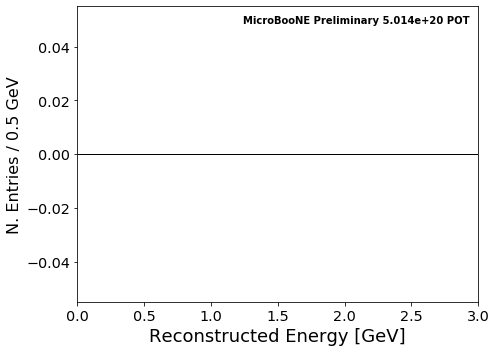

In [43]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_ext.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_ext.iloc[start:end]

    samples = {
        "numu_ext": sample_set 
    }


    if isRun3 == False:
        pot =  2e+20
        extratio  = 5268051/9199232.74 
        scalingEXT = 0.98
    elif isRun3 == True:
        pot =  5.014e+20
        extratio  = 10363728.0/32878305.25
        scalingEXT = 0.98
    
    # NUE
    weights = { "ext" : extratio * SPLIT * scalingEXT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
    #VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score


    VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_ext",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


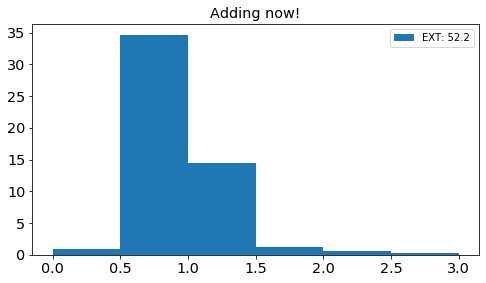

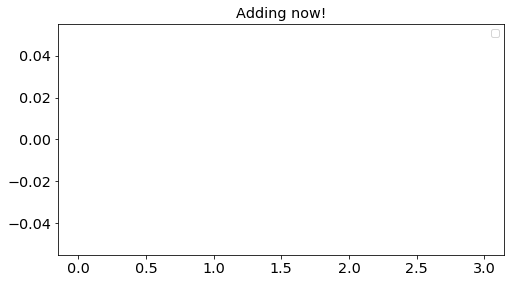

In [44]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #numu_ax1.set_xlim([-1, 1])    #AngleDiff


    numu_stacked = numu_ax1.hist(
                varss[i],
                weights=list(weightss[i]),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("Adding now!")
    plt.legend()

In [45]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = np.concatenate(varss)
weightss_tot = np.concatenate(weightss)

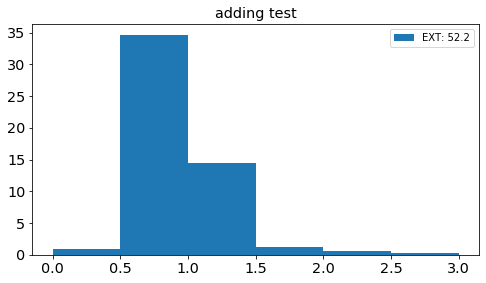

In [46]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss


numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 300])

#AngleDiff
#numu_ax1.set_xlim([-1, 1])
#numu_ax1.set_ylim([0, 80])

numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [47]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

numu_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, numu_stacked)

print(numu_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [48]:
#ending = "Jan19_NoCut"
#ending = "Jan19_TriggerCut"
#ending = "Jan19_VtxXCut"
#ending = "Jan19_VtxYCut"
#ending = "Jan19_VtxZCut"
#ending = "Jan19_MuonCut"
#ending = "Jan19_ProtonCut"
#ending = "Jan19_ShowerCut"
#ending = "Jan19_FracCut"
#ending = "Jan19_TopoCut"
ending = "Jan19"

In [49]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_ext_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_ext_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')


### Stat Errors

[0.96266893 5.88200434 3.81035341 1.11159434 0.78601589 0.55579717]


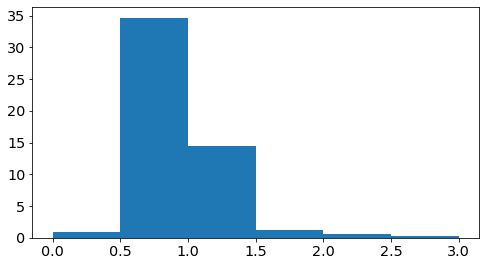

In [50]:
#A poisson uncertainty is assumed for beam off (see krishan's thesis p.182)

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 500])


numu_stacked = numu_ax1.hist(
            varss_tot,
            weights=list(weightss_tot),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)


numu_ext_stat_errs = np.sqrt(numu_stacked[0])

print(numu_ext_stat_errs)

In [51]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    elif (variable == "Angle"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_recoE_usingSelection_recoCut_run3_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_angleDiff_usingSelection_run3_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_ext_stat_errs_full_catsel_nopions_leptonMom_usingSelection_run3_"+ending+".csv", 
                   numu_ext_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    

## NUMU_DATA SAMPLE

In [5]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#BNB  = '/pre_samp/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
#full sample
if isRun3 == False:
    BNB  = '/neutrinoselection_filt_run1_beamon_beamgood' +ls.APPEND
elif isRun3 == True:
    BNB  = '/neutrinoselection_filt_run3b_beamon_beamgood' +ls.APPEND

#actually fetch datasets
numu_data  = uproot.open(ls.ntuple_path+BNB+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [numu_data]

numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe", "contained_fraction", 
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "shr_energy_tot_cali", "proton_e", "elec_e",
        "reco_e","trk_energy_tot","n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "nproton", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]


# These are examples of variables present in MC samples only
numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E"]


#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
numu_variables = list(set(numu_variables))
print(numu_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['evt', 'elec_e', 'interaction', 'run', 'npion', 'contained_fraction', 'category', 'reco_nu_vtx_sce_x', 'n_showers_contained', 'trk_range_muon_mom_v', 'slclustfrac', 'trk_sce_start_x_v', 'trk_sce_end_y_v', 'reco_e', 'reco_nu_vtx_x', 'nu_pdg', 'npi0', 'reco_nu_vtx_z', 'shr_energy_tot_cali', 'true_e_visible', 'nproton', 'trk_energy_tot', 'CosmicIP', 'slnunhits', 'proton_e', 'backtracked_pdg', 'flash_pe', 'evnunhits', 'CosmicDirAll3D', 'nmuon', 'topological_score', '_opfilter_pe_veto', 'sub', 'shr_tkfit_dedx_Y', 'tksh_distance', 'trk_theta', 'muon_e', 'nslice', 'trk_sce_end_z_v', 'pi0_e', 'trk_phi', 'CosmicIPAll3D', 'isVtxInFiducial', 'pion_e', 'trk_llr_pid_score_v', 'slpdg', 'reco_nu_vtx_sce_y', '_opfilter_pe_beam', 'trk_energy_muon', 'trk_sce_end_x_v', 'pi0truth_elec_etot', 'reco_nu_vtx_y', 'swtrig_pre', 'slnhits', 'trk_mcs_muon_mom_v', 'reco_nu_vtx_sce_z', 'ccnc']


In [6]:
import time
s = time.time()

import pandas as pandas

data_var  = numu_variables + numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_data] 
var_v    = [data_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_data = CVDF

s2 = time.time()
print(s2 - s)
#Approx 3 mins

trk_llr_pid_v  [[] [] [] ... [] [] []]
trk_score_v  [[] [] [] ... [] [] []]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
171.1035120487213


In [7]:
numu_data['pot_scale'] = [1 for x in range(len(numu_data))]

In [8]:
numu_data['totweight_data'] = numu_data['pot_scale']

In [9]:
df_v = [numu_data]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [10]:
df_v = [numu_data]
for i,df in enumerate(df_v):  
    #df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

numu_data["bnbdata"] = np.ones_like(numu_data["isVtxInFiducial"])

In [11]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5807/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  10.103512525558472


In [12]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [13]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [14]:
numu_data.query("nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0", inplace=True)# and n_showers_contained == 0", inplace=True)


In [15]:
#RECO VARIABLE
df_v = [numu_data]
    
s = time.time()

print(df["trk_sce_end_z_v"])

for i,df in enumerate(df_v):
    df["muon_mom"] = df["trk_sce_end_z_v"].copy()
    for j, row in df.iterrows():
        if (len(row["muon_mom"]) !=0 ) and (df["trk_sce_end_z_v"][j][0] < 1036.8 and df["trk_sce_end_z_v"][j][0] > 0 and df["trk_sce_end_y_v"][j][0] < 116.5 and df["trk_sce_end_y_v"][j][0] > -116.5 and df["trk_sce_end_x_v"][j][0] < \
         254.8 and df["trk_sce_end_x_v"][j][0] > -1.55):
            df.loc[j, "muon_mom"] = df["trk_range_muon_mom_v"][j][0]
        elif (len(row["muon_mom"]) == 0 ):
            df.loc[j, "muon_mom"] = 0
        else:
            df.loc[j, "muon_mom"] = df["trk_mcs_muon_mom_v"][j][0]  #mcs == multiple coulob scattering
        
print(df["muon_mom"])
print("")
s2 = time.time()
print("runetime = ", s2-s)

entry
490                                    [156.18512, 246.7878]
588        [463.3852, 382.20358, 343.10248, 334.58636, 31...
1186                                    [656.6905, 601.3882]
1236                                   [831.45514, 857.1822]
1425                                   [394.6405, 395.75952]
                                 ...                        
1103342    [437.044, 446.21927, 422.78644, 378.04797, 366...
1103440                               [297.51132, 121.85714]
1103554                               [258.51245, 249.91241]
1103612                       [687.439, 641.95935, 639.3839]
1104343           [952.66113, 889.01483, 773.8401, 790.5579]
Name: trk_sce_end_z_v, Length: 5673, dtype: object
entry
490        0.361931
588        0.440964
1186       0.318456
1236       0.215977
1425       0.211738
             ...   
1103342    0.570996
1103440     0.54621
1103554    0.345876
1103612    0.381335
1104343    0.644393
Name: muon_mom, Length: 5673, dtype: object

r

In [16]:
#RECO VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['nu_Angle_Numi_Muon_Reco'] = df.apply( lambda x: angleFromNuMITarget(x['reco_nu_vtx_sce_x'],x['reco_nu_vtx_sce_y'],x['reco_nu_vtx_sce_z'], x['trk_theta'],x['trk_phi']) , axis=1)
    df['cosNu_Angle_Numi_Muon_Reco'] = np.cos(df['nu_Angle_Numi_Muon_Reco'])

In [17]:
#Calculate the total KE of all protons
#proton_e is only that of the highest energy proton

s = time.time()

Mp = 0.938272046
df_v = [numu_data]

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.06556129455566406


In [18]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [19]:
df_v = [numu_data]
for i,df in enumerate(df_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                     & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                     & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                     & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                     & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

Set up complete.

In [20]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1


samples = {
    "numu_data"  : numu_data
}

if isRun3 == False:
    pot       =  2e+20
elif isRun3 == True:
    pot       =  5.014e+20    

SPLIT = 1.0
scaling = 1

weights = { }

my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
print(weights)

{}


In [21]:
"""
#No true as is data
"""
NUMU_SEL_QUERY = "nslice == 1 and ( (_opfilter_pe_beam > 0 \
and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) \
and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 \
and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 \
and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 \
and n_muons_tot > 0 and n_protons_tot > 0"# and n_showers_contained==0  \
#and contained_fraction> 0.95 and topological_score > 0.3"


SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
SIGNAL_NUMU_SEL_QUERY += 'and is_signal==True'

NOT_SIGNAL_NUMU_SEL_QUERY = NUMU_SEL_QUERY
NOT_SIGNAL_NUMU_SEL_QUERY += 'and is_signal==False'

In [22]:
test = np.nansum(numu_data.query(NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 5673


In [20]:
#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 5)
tmp[mask] = 4.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

entry
0         0.105
1         0.105
2         0.105
3         0.105
4         0.105
          ...  
610491    0.105
610492    0.105
610493    0.105
610494    0.105
610495    0.105
Name: reco_e, Length: 610496, dtype: float32
entry
0         0.105
1         0.105
2         0.105
3         0.105
4         0.105
          ...  
610491    0.105
610492    0.105
610493    0.105
610494    0.105
610495    0.105
Name: reco_e, Length: 610496, dtype: float32


In [23]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["reco_e"].copy()
mask = (df["reco_e"] > 3)
tmp[mask] = 2.75
df["reco_e"] = tmp
print(df["reco_e"])
#------
tmp = df["reco_e"].copy()
mask = (df["reco_e"] < 0)
tmp[mask] = 0.25
df["reco_e"] = tmp
print(df["reco_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])
#------
tmp = df["cosNu_Angle_Numi_Muon_Reco"].copy()
mask = (df["cosNu_Angle_Numi_Muon_Reco"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon_Reco"] = tmp
print(df["cosNu_Angle_Numi_Muon_Reco"])

#LEPTON
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] > 2)
tmp[mask] = 1.875
df["muon_mom"] = tmp
print(df["muon_mom"])
#------
tmp = df["muon_mom"].copy()
mask = (df["muon_mom"] < 0)
tmp[mask] = 0.125
df["muon_mom"] = tmp
print(df["muon_mom"])

entry
490        1.086940
1186       0.896911
1236       0.681826
1425       0.599639
1594       1.751767
             ...   
1103342    1.374887
1103440    1.262710
1103554    0.858253
1103612    1.040717
1104343    1.525543
Name: reco_e, Length: 3589, dtype: float32
entry
490        1.086940
1186       0.896911
1236       0.681826
1425       0.599639
1594       1.751767
             ...   
1103342    1.374887
1103440    1.262710
1103554    0.858253
1103612    1.040717
1104343    1.525543
Name: reco_e, Length: 3589, dtype: float32
entry
490       -0.420757
1186       0.281630
1236      -0.145603
1425      -0.252480
1594       0.883051
             ...   
1103342    0.783950
1103440    0.784281
1103554    0.407018
1103612    0.742558
1104343    0.438909
Name: cosNu_Angle_Numi_Muon_Reco, Length: 3589, dtype: float64
entry
490       -0.420757
1186       0.281630
1236      -0.145603
1425      -0.252480
1594       0.883051
             ...   
1103342    0.783950
1103440    0.784281
1103554

Set up complete

No handles with labels found to put in legend.


n_events here =  5673

1.0
1
nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 15 and reco_nu_vtx_sce_x < 245 and reco_nu_vtx_sce_y > -105 and reco_nu_vtx_sce_y < 105 and reco_nu_vtx_sce_z > 10 and reco_nu_vtx_sce_z < 990 and n_muons_tot > 0 and n_protons_tot > 0& n_showers_contained <= 10 & n_showers_contained >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_data
--------------------------------------
Should not be here...
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  0.0
0.000000000000000000000000000000000000000000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  0.0
0.00000000000000000

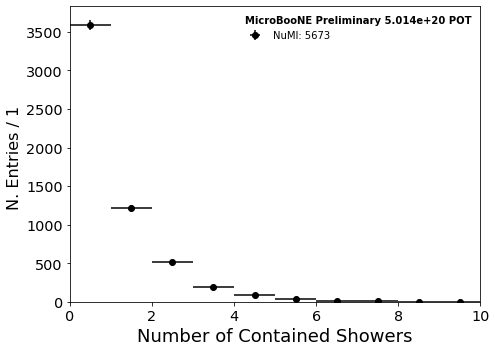

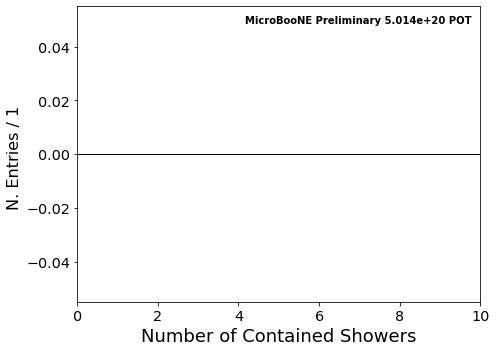

In [23]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_data.shape[0]
print("n_events here = ", n_events)
print("")
#batch_size = 40000
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_data.iloc[start:end]

    samples = {
        "numu_data": sample_set 
    }

    if isRun3 == False:
        pot =  2e+20 
    elif isRun3 == True:
        pot =  5.014e+20 
        
    weights = {  
                }
    
    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]" #NoCut, TriggerCut
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_x',60,(-20.0, 280.0),"Vertex X [cm]" #VtxX
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_y',56,(-140.0, 140.0),"Vertex Y [cm]"  #VtxY
    #VARIABLE, BINS, RANGE, XTIT = 'reco_nu_vtx_sce_z',56,(-10.0, 1110.0),"Vertex Z [cm]"   #VtxZ
    #VARIABLE, BINS, RANGE, XTIT = 'n_muons_tot',5,(0, 5),"Number of Muons"  #Muons
    #VARIABLE, BINS, RANGE, XTIT = 'n_protons_tot',8,(0, 8),"Number of Protons"   #Protons
    VARIABLE, BINS, RANGE, XTIT = 'n_showers_contained',10,(0, 10),"Number of Contained Showers"  #Showers
    #VARIABLE, BINS, RANGE, XTIT = 'contained_fraction',20,(0, 1),"Contained Fraction"   #Cont Frac
    #VARIABLE, BINS, RANGE, XTIT = 'topological_score',10,(0.0, 1.0),"Topological Score"  #Topo score


    
    #VARIABLE, BINS, RANGE, XTIT = 'reco_e',6,(0.0, 3.0),"Reconstructed Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon_Reco',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_mom',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= NUMU_SEL_QUERY,
        #query= "",
        currentsample = "numu_data",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


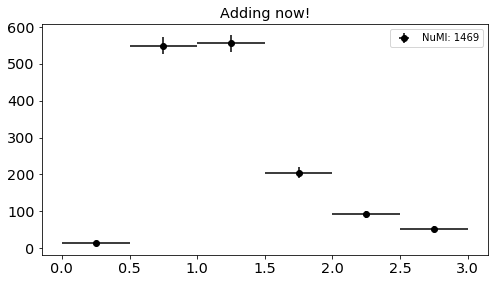

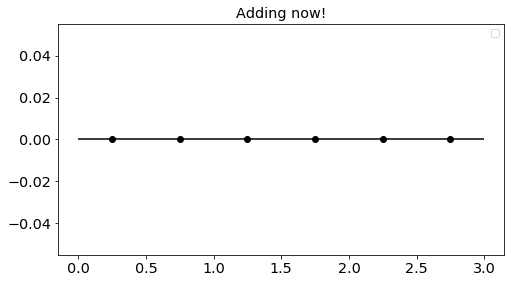

In [37]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    numu_fig = plt.figure(figsize=(8, 7))
    numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    numu_ax1 = plt.subplot(numu_gs[0])
    #numu_ax1.set_xlim([0, 5])    #TrueE, lepton mom, muons
    #current_bincenters =  np.arange(0.25, 5.25, 0.5)
    #current_bin_size = 0.5
    #current_bincenters =  np.arange(0.5, 5.5, 1)
    #current_bin_size = 1
    ########################
    #numu_ax1.set_xlim([-20, 280])    #X
    #current_bincenters =  np.arange(-17.5, 282.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-140, 140])    #Y
    #current_bincenters =  np.arange(-137.5, 142.5, 5)
    #current_bin_size = 5
    ########################
    #numu_ax1.set_xlim([-10, 1100])    #Z
    #current_bincenters =  np.arange(0, 1110, 20)
    #current_bin_size = 20
    ########################
    #numu_ax1.set_xlim([0, 1])    #Cont
    #current_bincenters =  np.arange(0.025, 1, 0.05)
    #current_bin_size = 0.05
    ########################
    
    #Energy
    current_bincenters =  np.arange(0.25, 3.25, 0.5)
    current_bin_size = 0.5
    #AngleDiff
    #current_bincenters =  np.arange(-0.9, 1.1, 0.2)
    #current_bin_size = 0.25
    #Lepton
    #current_bincenters =  np.arange(0.125, 2.125, 0.25)
    #current_bin_size = 0.25

    numu_ax1.errorbar(
                current_bincenters,
                varss[i],
                xerr=current_bin_size/2,
                yerr=weightss[i],
                fmt='ko',
                label="NuMI: %i" % sum(varss[i]) if sum(varss[i]) else "")
    
    plt.title("Adding now!")
    plt.legend()

In [24]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = sum(varss)
print(weightss[0][0])
#sum errors? will need to change if splitting data
weightss_tot = weightss[0][0]

[59.9082632  34.92849839 22.82542442 13.85640646  9.64365076  6.164414
  3.46410162  2.44948974  1.41421356  0.        ]


[1595  567  228   67   30   10    4    5    0    1]


NameError: name 'current_bincenters' is not defined

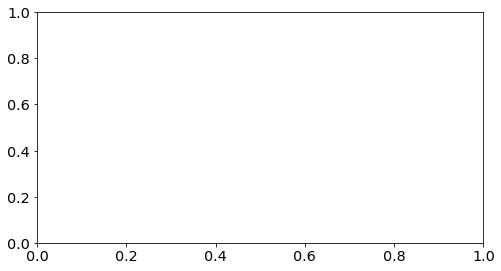

In [25]:
from matplotlib import gridspec

category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = labss

numu_fig = plt.figure(figsize=(8, 7))
numu_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
numu_ax1 = plt.subplot(numu_gs[0])

#TrueE, LeptonMom
#numu_ax1.set_xlim([0, 5])
#numu_ax1.set_ylim([0, 4000])

#AngleDiff
#numu_ax1.set_xlim([-1,1])
#numu_ax1.set_ylim([0, 900])

print(varss_tot)

numu_ax1.errorbar(
            current_bincenters,
            varss_tot,
            xerr=current_bin_size/2,
            yerr=weightss_tot,
            fmt='ko',
            label="NuMI: %i" % sum(varss_tot) if sum(varss_tot) else "")


plt.title("adding test")
plt.legend()

In [25]:
#ending = "Jan19_NoCut"
#ending = "Jan19_TriggerCut"
#ending = "Jan19_VtxXCut"
#ending = "Jan19_VtxYCut"
#ending = "Jan19_VtxZCut"
#ending = "Jan19_MuonCut"
#ending = "Jan19_ProtonCut"
ending = "Jan19_ShowerCut"
#ending = "Jan19_FracCut"
#ending = "Jan19_TopoCut"
#ending = "Jan19"

In [26]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if isRun3 == False:
    #######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_'+ending+'.csv')
elif isRun3 == True:
    #######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_recoE_usingSelection_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_angleDiff_usingSelection_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_data_varstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_data_weightstot_full_catsel_nopions_leptonMom_usingSelection_run3_'+ending+'.csv')
